### 6. Segmentation with SAMv2 (Segment Anything Model)


image 1/1 /home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/JPEGImages/train/191571.jpg: 640x448 1 jacket, 1 shirt, 1 pants, 1 bag, 1 shoe, 15.6ms
Speed: 2.0ms preprocess, 15.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


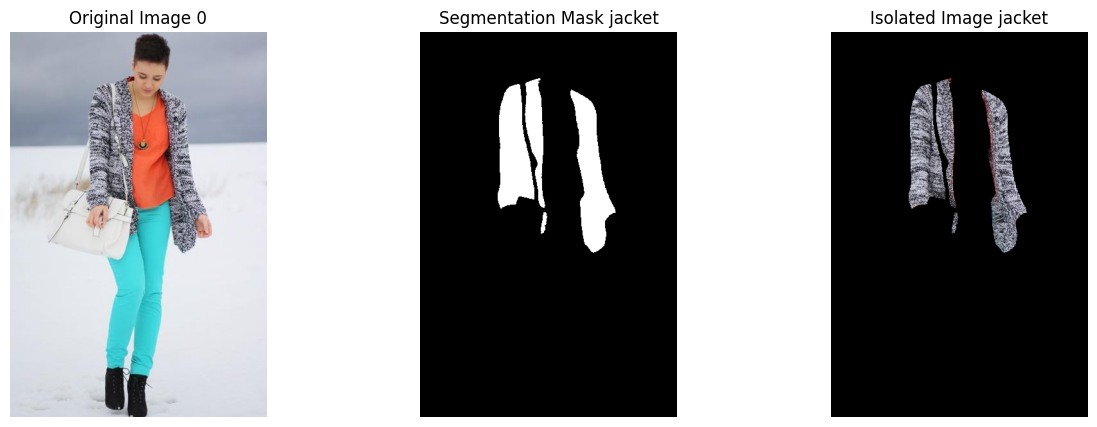

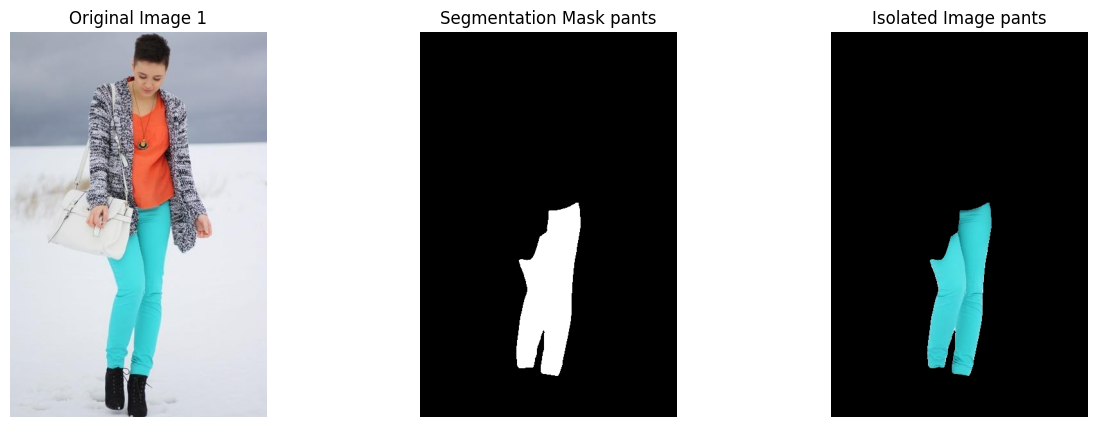

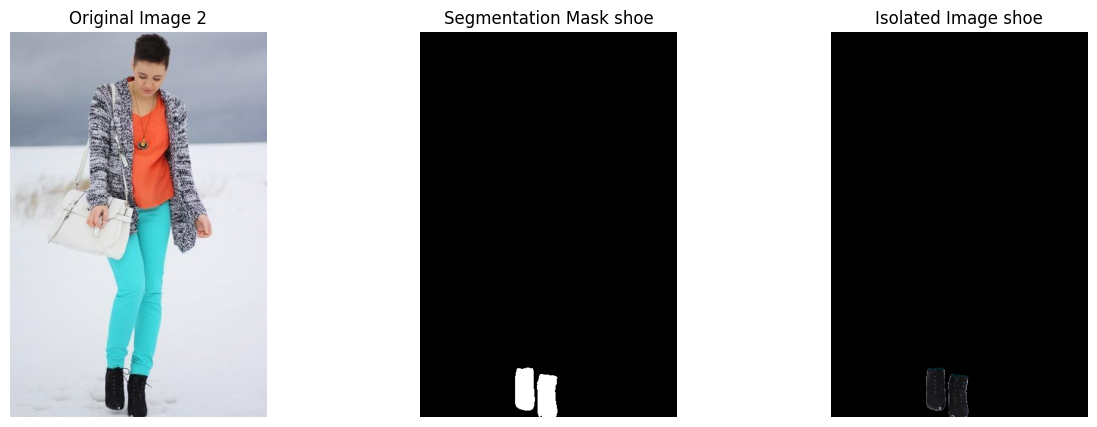

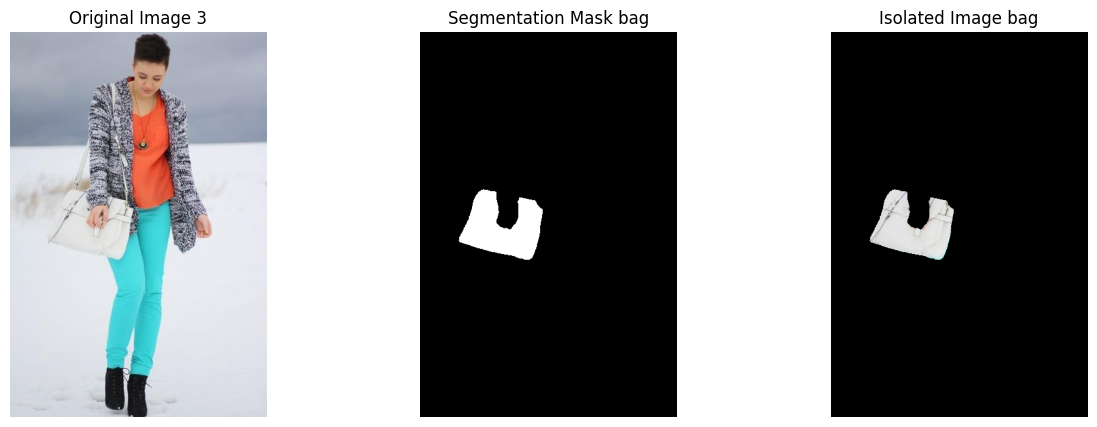

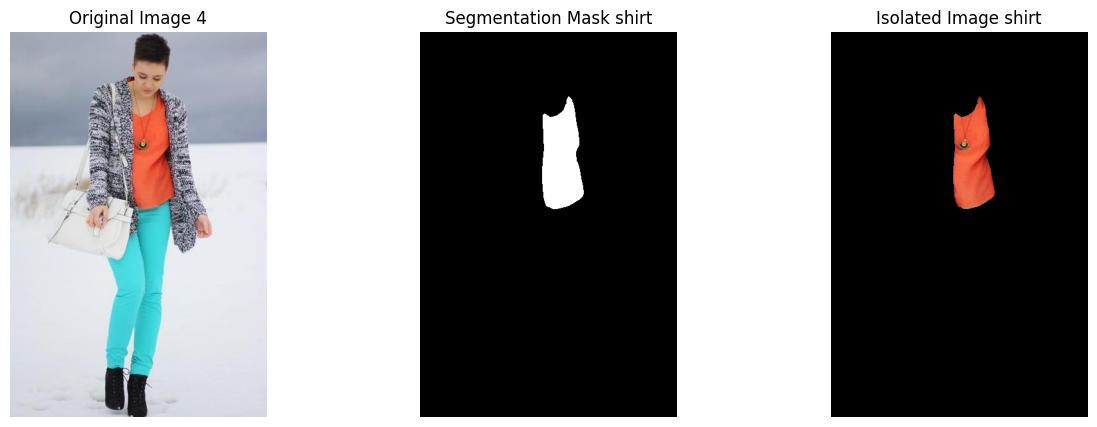

Segmentation complete.


In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import torch
from ultralytics import YOLO
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from torchvision.ops import nms

torch.cuda.empty_cache()

def apply_nms(detected_items, iou_threshold=0.5):
    """
    Apply Non-Maximum Suppression (NMS) to filter overlapping boxes.
    """
    boxes = [item['coordinates'] for item in detected_items]
    scores = [item['confidence'] for item in detected_items]
    labels = [item['label'] for item in detected_items]
    
    boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
    scores_tensor = torch.tensor(scores, dtype=torch.float32)

    # Apply NMS
    nms_indices = nms(boxes_tensor, scores_tensor, iou_threshold)
    
    # Filter boxes, scores, and labels based on NMS output
    nms_boxes = boxes_tensor[nms_indices].tolist()
    nms_scores = scores_tensor[nms_indices].tolist()
    nms_labels = [labels[i] for i in nms_indices]

    # Reformat the filtered results into the detected_items structure
    nms_items = []
    for i in range(len(nms_boxes)):
        nms_items.append({
            'label': nms_labels[i],
            'coordinates': nms_boxes[i],
            'confidence': nms_scores[i]
        })
    return nms_items

def conflict_resolution(items):
    """
    Apply conflict resolution based on predefined conflicting object pairs.
    """
    final_items = []
    items_dict = {}
    for i, item in enumerate(items):
        items_dict[item['label']] = {'confidence': item['confidence'], 'idx': i}

    conflicts = {
        'shirt': ['dress'],
        'pants': ['shorts', 'skirt'],
        'shorts': ['pants', 'skirt'],
        'skirt': ['pants', 'shorts'],
        'dress': ['shirt']
    }

    conflict_pairs = []
    for k in items_dict.keys():
        if k not in conflicts:
            final_items.append(items[items_dict[k]['idx']])
        else:
            flag = True
            for conflict in conflicts[k]:
                if conflict in items_dict.keys():
                    if set([k, conflict]) not in conflict_pairs:
                        conflict_pairs.append(set([k, conflict]))
                    flag = False
            if flag:
                final_items.append(items[items_dict[k]['idx']])

    for i, pair in enumerate(conflict_pairs):
        conflict_pairs[i] = list(pair)
    
    winners = []
    for pair in conflict_pairs:
        if pair[0] in winners:
            final_items.append(items[items_dict[pair[0]]['idx']])
        elif pair[1] in winners:
            final_items.append(items[items_dict[pair[1]]['idx']])
        elif items_dict[pair[0]]['confidence'] > items_dict[pair[1]]['confidence']:
            final_items.append(items[items_dict[pair[0]]['idx']])
            winners.append(pair[0])
        else:
            final_items.append(items[items_dict[pair[1]]['idx']])
            winners.append(pair[1])
    
    return final_items

def detect_and_segment_objects(base_path, sample_image_path, yolo_weights_path, sam2_weights_path, sam2_config_path):
    """
    Detect objects using YOLO, resolve conflicts, and apply SAM2 for segmentation.
    """
    segmented_images_dir = os.path.join(base_path, "segmented_images")
    os.makedirs(segmented_images_dir, exist_ok=True)

    # Load the SAMv2 model
    mask_predictor = SAM2ImagePredictor(build_sam2(sam2_config_path, sam2_weights_path))

    # Load the YOLO model
    model = YOLO(yolo_weights_path)

    # Load sample image
    image = Image.open(sample_image_path).convert('RGB')
    image_rgb = np.array(image)
    image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)

    # Perform object detection with YOLO
    results = model(sample_image_path)

    # Collect detected items
    detected_items = []
    for result in results:
        boxes = result.boxes
        for box in boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Get bounding box coordinates
            confidence = box.conf[0].item()  # Get confidence score
            class_id = int(box.cls[0])  # Get class id
            label = model.names[class_id]  # Get label for class id

            detected_items.append({
                'label': label,
                'coordinates': (x1, y1, x2, y2),
                'confidence': confidence
            })

    # Apply NMS to filter out overlapping boxes
    resolved_items = apply_nms(detected_items)

    # Apply conflict resolution
    resolved_items = conflict_resolution(resolved_items)

    # Prepare boxes for SAMv2 segmentation
    predicted_boxes = np.array([item['coordinates'] for item in resolved_items])
    
    # Set the image for SAMv2 to generate segmentation masks
    mask_predictor.set_image(image_bgr)

    # Generate segmentation masks with SAMv2
    masks, _, _ = mask_predictor.predict(
        point_coords=None,
        point_labels=None,
        box=predicted_boxes[None, :],
        multimask_output=False,
    )

    labels = [item['label'] for item in resolved_items]

    # Save and visualize each mask separately using the label name
    for i, mask in enumerate(masks):
        mask = mask[0].astype(np.uint8)  # Ensure mask is already numpy.uint8 type

        # Save the mask with the class label in the filename
        mask_image = Image.fromarray(mask * 255)  # Convert mask to binary image
        mask_filename = os.path.join(segmented_images_dir, f"{labels[i]}_mask_{i}.png")
        mask_image.save(mask_filename)

        # Multiply the mask by the original image to isolate the object
        isolated_image = image_rgb * mask[:, :, np.newaxis]

        # Save the isolated image with the class label in the filename
        isolated_filename = os.path.join(segmented_images_dir, f"{labels[i]}_isolated_{i}.png")
        isolated_image_pil = Image.fromarray(isolated_image)
        isolated_image_pil.save(isolated_filename)

        # Visualize the mask and the isolated image
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image_rgb)
        plt.title(f"Original Image {i}")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f"Segmentation Mask {labels[i]}")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(isolated_image)
        plt.title(f"Isolated Image {labels[i]}")
        plt.axis('off')

        plt.show()

    print("Segmentation complete.")

# Example usage:
base_path = '/home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering'
jpeg_images_path = "JPEGImages"
train_image_path = os.path.join(jpeg_images_path, "train")

# Load the trained YOLO model
runs_path = os.path.join(base_path, 'runs', 'detect')
weights_save_path = os.path.join(runs_path, 'train', 'weights')
yolo_best_weights_path = os.path.join(weights_save_path, "best.pt")

# Paths for SAMv2
sam2_weights_path = os.path.join(base_path, "segment-anything-2/checkpoints/sam2_hiera_large.pt")
sam2_config_path = "sam2_hiera_l.yaml"

# Select a sample image
sample_image_path = os.path.join(train_image_path, "191571.jpg")  # Replace with your image

# Perform detection and segmentation
detect_and_segment_objects(base_path, sample_image_path, yolo_best_weights_path, sam2_weights_path, sam2_config_path)

in this implementation we employed samv2 segmentation model for getting segmnetation masks  from each clothing item, then each segmentation mask multiplied  by original image and gives us back the isolated RGB Image.

#### 6.1. getting RGBA Isolated image from each RGB Isolated clothing item


image 1/1 /home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/JPEGImages/train/191571.jpg: 640x448 1 jacket, 1 shirt, 1 pants, 1 bag, 1 shoe, 17.6ms
Speed: 1.5ms preprocess, 17.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


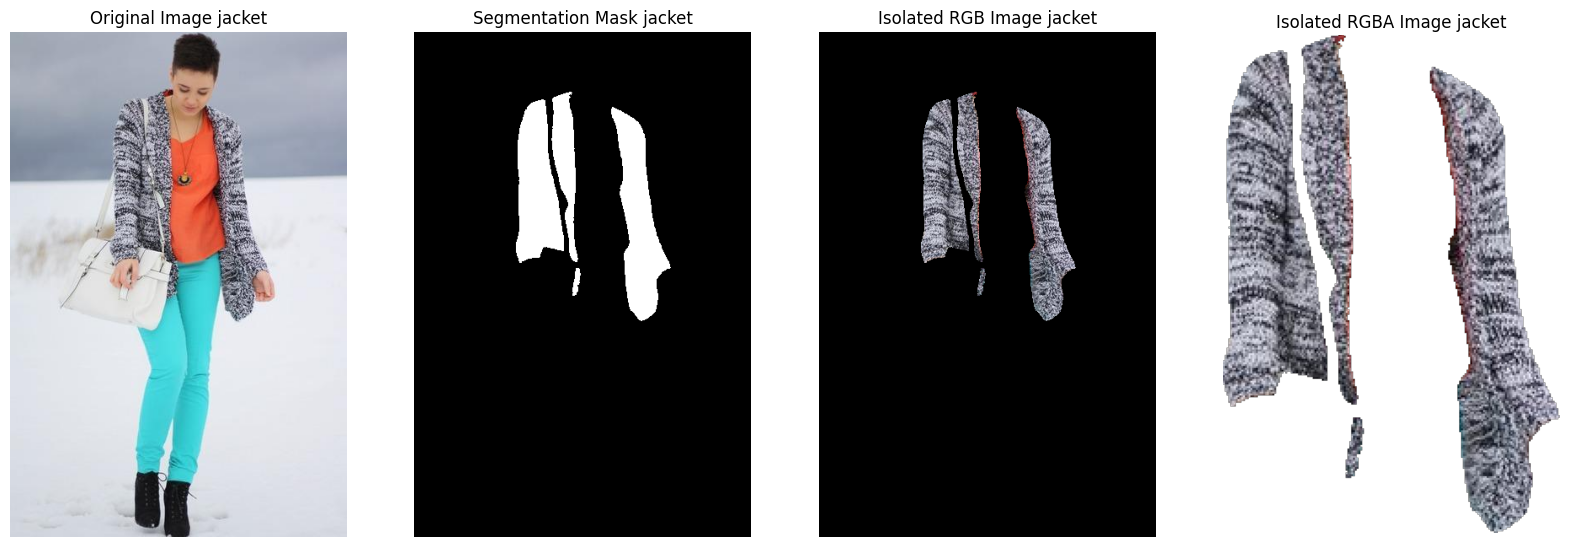

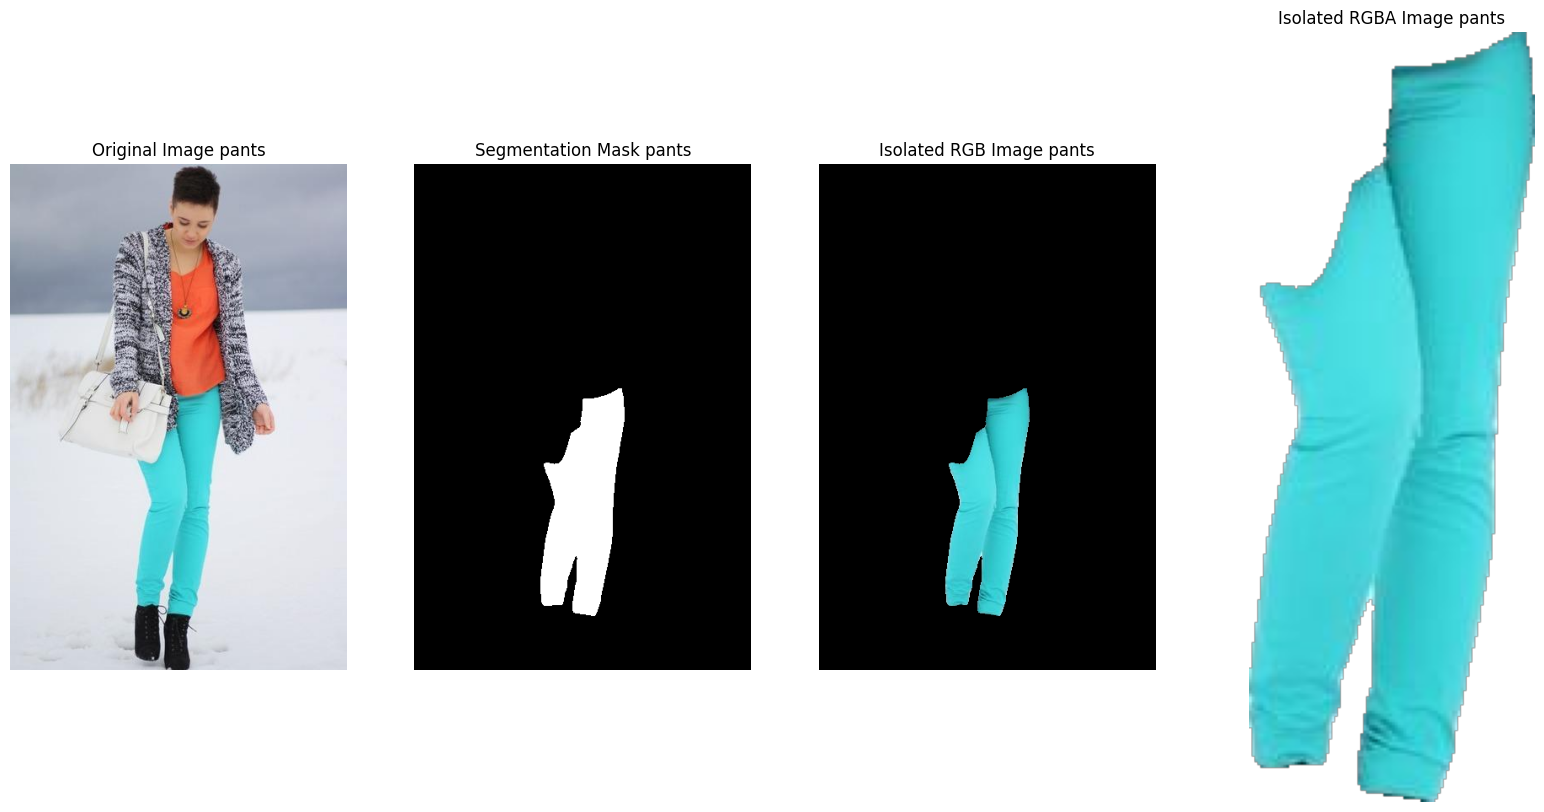

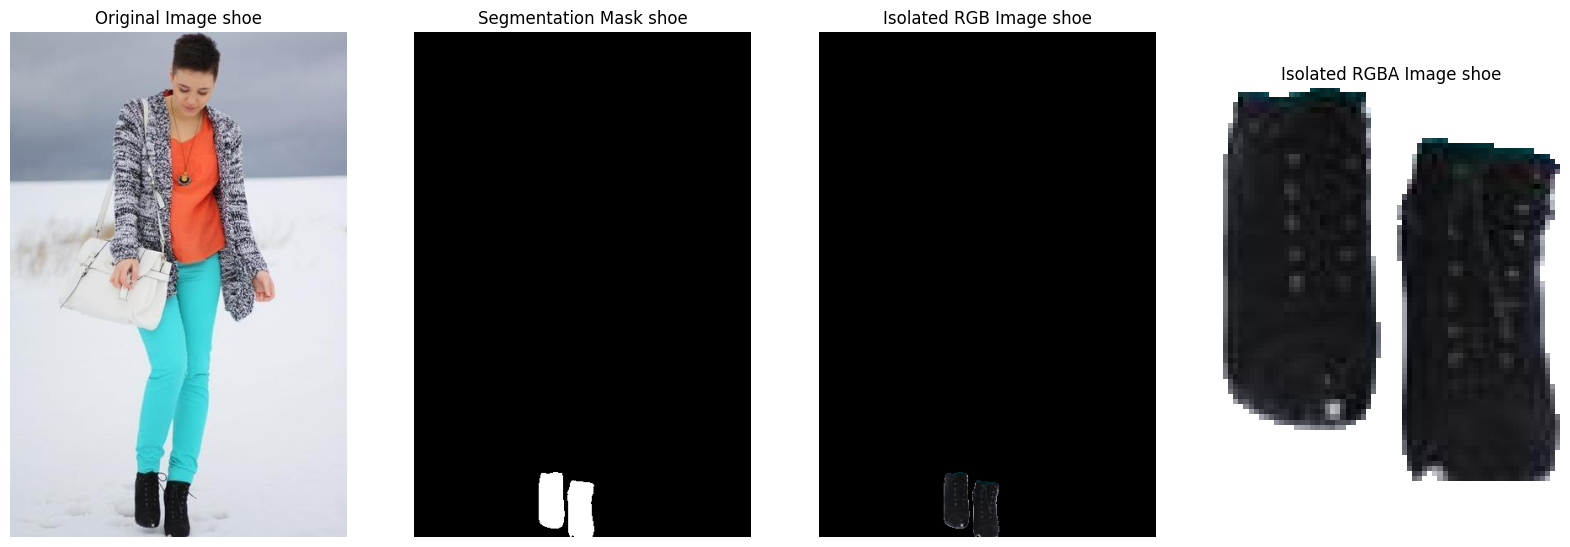

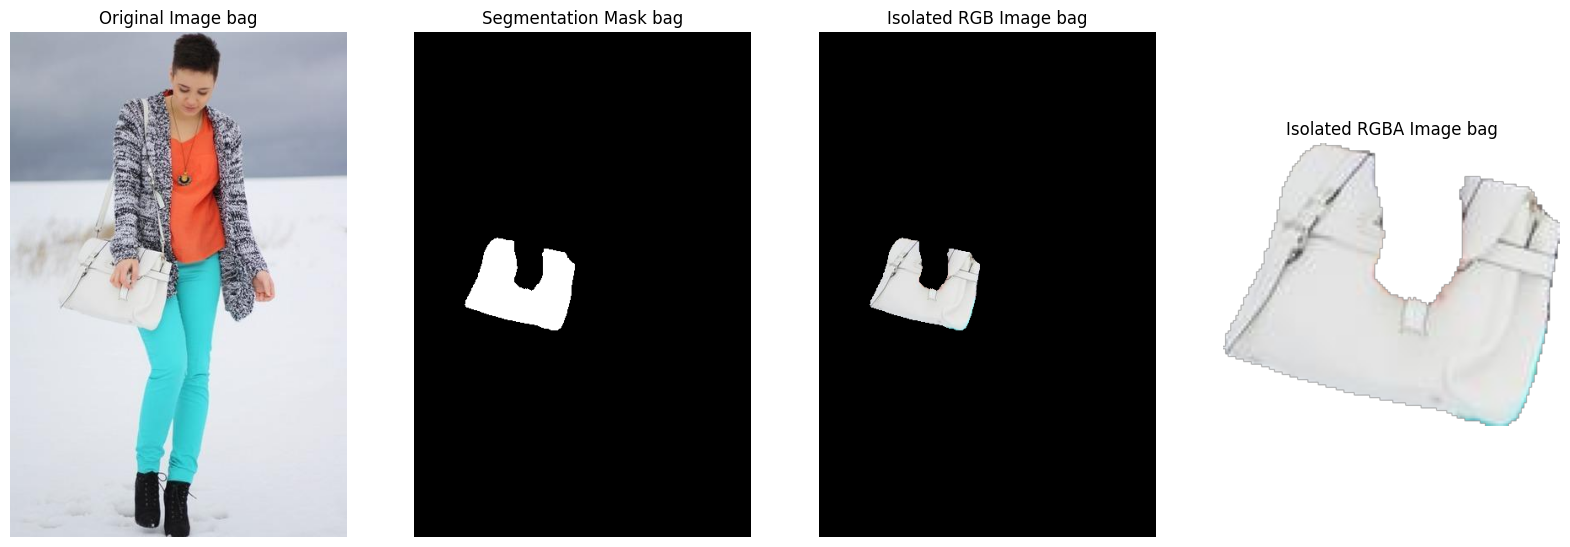

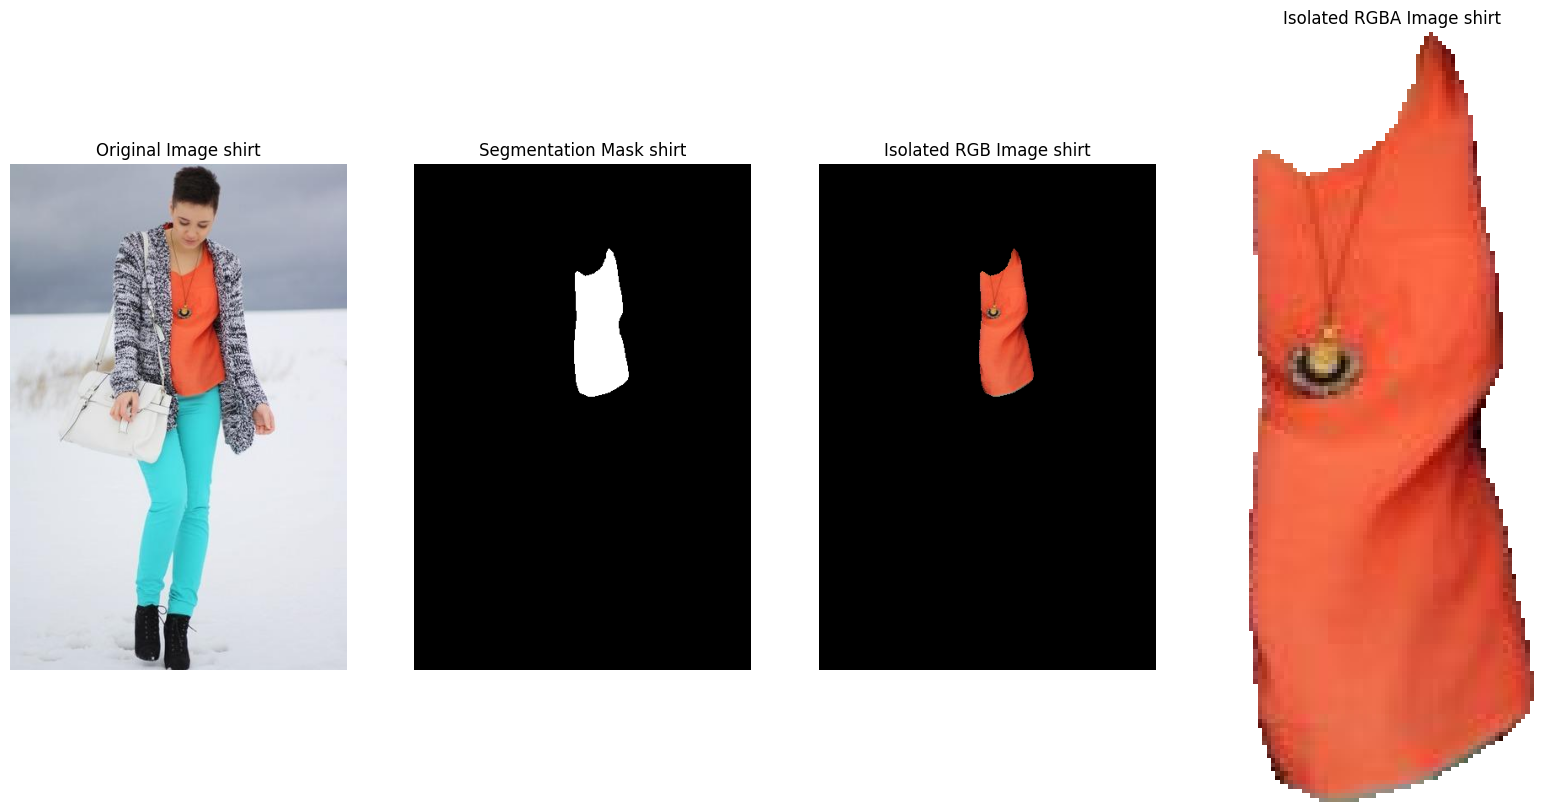

Segmentation complete.


In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import torch
from ultralytics import YOLO
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from torchvision.ops import nms

torch.cuda.empty_cache()

def apply_nms(detected_items, iou_threshold=0.5):
    """
    Apply Non-Maximum Suppression (NMS) to filter overlapping boxes.
    """
    boxes = [item['coordinates'] for item in detected_items]
    scores = [item['confidence'] for item in detected_items]
    labels = [item['label'] for item in detected_items]
    
    boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
    scores_tensor = torch.tensor(scores, dtype=torch.float32)

    # Apply NMS
    nms_indices = nms(boxes_tensor, scores_tensor, iou_threshold)
    
    # Filter boxes, scores, and labels based on NMS output
    nms_boxes = boxes_tensor[nms_indices].tolist()
    nms_scores = scores_tensor[nms_indices].tolist()
    nms_labels = [labels[i] for i in nms_indices]

    # Reformat the filtered results into the detected_items structure
    nms_items = []
    for i in range(len(nms_boxes)):
        nms_items.append({
            'label': nms_labels[i],
            'coordinates': nms_boxes[i],
            'confidence': nms_scores[i]
        })
    return nms_items

# function conflict resolution
def conflict_resolution(items):
    """
    Resolve conflicts between similar classes like 'shirt' vs 'dress', etc.
    """
    final_items = []
    items_dict = {}
    for i, item in enumerate(items):
        items_dict[item['label']] = {'confidence': item['confidence'], 'idx': i}

    conflicts = {
        'shirt': ['dress'],
        'pants': ['shorts', 'skirt'],
        'shorts': ['pants', 'skirt'],
        'skirt': ['pants', 'shorts'],
        'dress': ['shirt']
    }

    conflict_pairs = []
    for k in items_dict.keys():
        if k not in conflicts:
            final_items.append(items[items_dict[k]['idx']])
        else:
            flag = True
            for conflict in conflicts[k]:
                if conflict in items_dict.keys():
                    if set([k, conflict]) not in conflict_pairs:
                        conflict_pairs.append(set([k, conflict]))
                    flag = False
            if flag:
                final_items.append(items[items_dict[k]['idx']])

    for i, pair in enumerate(conflict_pairs):
        conflict_pairs[i] = list(pair)
    winners = []

    for pair in conflict_pairs:
        if pair[0] in winners:
            final_items.append(items[items_dict[pair[0]]['idx']])
        elif pair[1] in winners:
            final_items.append(items[items_dict[pair[1]]['idx']])
        elif items_dict[pair[0]]['confidence'] > items_dict[pair[1]]['confidence']:
            final_items.append(items[items_dict[pair[0]]['idx']])
            winners.append(pair[0])
        else:
            final_items.append(items[items_dict[pair[1]]['idx']])
            winners.append(pair[1])

    return final_items

def detect_and_segment_objects(base_path, sample_image_path, yolo_weights_path, sam2_weights_path, sam2_config_path):
    """
    Detect objects using YOLO, resolve conflicts, and apply SAM2 for segmentation.
    """
    segmented_images_dir = os.path.join(base_path, "segmented_images")
    segmented_cropped_images_dir = os.path.join(base_path, "segmented_cropped")
    os.makedirs(segmented_images_dir, exist_ok=True)
    os.makedirs(segmented_cropped_images_dir, exist_ok=True)

    # Load the SAMv2 model
    mask_predictor = SAM2ImagePredictor(build_sam2(sam2_config_path, sam2_weights_path))

    # Load the YOLO model
    model = YOLO(yolo_weights_path)

    # Load sample image
    image = Image.open(sample_image_path).convert('RGB')
    image_rgb = np.array(image)
    image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)

    # Perform object detection with YOLO
    results = model(sample_image_path)

    # Collect detected items
    detected_items = []
    for result in results:
        boxes = result.boxes
        for box in boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Get bounding box coordinates
            confidence = box.conf[0].item()  # Get confidence score
            class_id = int(box.cls[0])  # Get class id
            label = model.names[class_id]  # Get label for class id

            detected_items.append({
                'label': label,
                'coordinates': (x1, y1, x2, y2),
                'confidence': confidence
            })

    # Apply NMS to filter out overlapping boxes
    resolved_items = apply_nms(detected_items)

    # Resolve conflicts
    resolved_items = conflict_resolution(resolved_items)

    # Prepare boxes for SAMv2 segmentation
    predicted_boxes = np.array([item['coordinates'] for item in resolved_items])
    
    # Set the image for SAMv2 to generate segmentation masks
    mask_predictor.set_image(image_bgr)

    # Generate segmentation masks with SAMv2
    masks, _, _ = mask_predictor.predict(
        point_coords=None,
        point_labels=None,
        box=predicted_boxes[None, :],
        multimask_output=False,
    )

    labels = [item['label'] for item in resolved_items]

    # Save and visualize each mask separately (both isolated RGB and RGBA images)
    for i, mask in enumerate(masks):
        mask = mask[0].astype(np.uint8)  # Ensure mask is uint8 type

        # Multiply the mask by the original image to isolate the object (RGB format)
        isolated_rgb_image = image_rgb * mask[:, :, np.newaxis]

        # Save the RGB isolated image
        isolated_rgb_filename = os.path.join(segmented_images_dir, f"{labels[i]}_isolated_rgb_{i}.png")
        isolated_rgb_image_pil = Image.fromarray(isolated_rgb_image)
        isolated_rgb_image_pil.save(isolated_rgb_filename)

        # Find the bounding box of the non-background pixels in the isolated image
        coords = np.column_stack(np.where(mask > 0))
        if coords.size == 0:
            print(f"No object found for mask {i}")
            continue
        y1, x1 = coords.min(axis=0)
        y2, x2 = coords.max(axis=0)

        # Crop the isolated image using the bounding box
        isolated_cropped_image = isolated_rgb_image[y1:y2+1, x1:x2+1]

        # Create an RGBA image with a transparent background
        isolated_cropped_image_rgba = np.zeros((y2 - y1 + 1, x2 - x1 + 1, 4), dtype=np.uint8)
        isolated_cropped_image_rgba[..., :3] = isolated_cropped_image
        isolated_cropped_image_rgba[..., 3] = mask[y1:y2+1, x1:x2+1] * 255  # Set the alpha channel based on the mask

        # Save the RGBA isolated image
        isolated_cropped_filename = os.path.join(segmented_cropped_images_dir, f"{labels[i]}_isolated_rgba_{i}.png")
        isolated_cropped_image_rgba_pil = Image.fromarray(isolated_cropped_image_rgba, 'RGBA')
        isolated_cropped_image_rgba_pil.save(isolated_cropped_filename)

        # Visualize the original image, mask, isolated RGB, and isolated RGBA images in 4 columns
        plt.figure(figsize=(20, 10))

        # Plot original image
        plt.subplot(1, 4, 1)
        plt.imshow(image_rgb)
        plt.title(f"Original Image {labels[i]}")
        plt.axis('off')

        # Plot segmented mask
        plt.subplot(1, 4, 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f"Segmentation Mask {labels[i]}")
        plt.axis('off')

        # Plot isolated RGB image
        plt.subplot(1, 4, 3)
        plt.imshow(isolated_rgb_image_pil)
        plt.title(f"Isolated RGB Image {labels[i]}")
        plt.axis('off')

        # Plot isolated RGBA image
        plt.subplot(1, 4, 4)
        plt.imshow(isolated_cropped_image_rgba_pil)
        plt.title(f"Isolated RGBA Image {labels[i]}")
        plt.axis('off')

        plt.show()

    print("Segmentation complete.")

# Example usage:
base_path = '/home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering'
jpeg_images_path = "JPEGImages"
train_image_path = os.path.join(jpeg_images_path, "train")

# Load the trained YOLO model
runs_path = os.path.join(base_path, 'runs', 'detect')
weights_save_path = os.path.join(runs_path, 'train', 'weights')
yolo_best_weights_path = os.path.join(weights_save_path, "best.pt")

# Paths for SAMv2
sam2_weights_path = os.path.join(base_path, "segment-anything-2/checkpoints/sam2_hiera_large.pt")
sam2_config_path = "sam2_hiera_l.yaml"

# Select a sample image
sample_image_path = os.path.join(train_image_path, "191571.jpg")  # Replace with your image

# Perform detection and segmentation
detect_and_segment_objects(base_path, sample_image_path, yolo_best_weights_path, sam2_weights_path, sam2_config_path)

-When performing image segmentation and preparing the image for KMeans clustering, it is crucial to isolate the region of interest (the object) from the background.

- After applying the segmentation mask to isolate the object from the background, the mask will have non-zero values where the object is present and zero values where the background is.

- By identifying the bounding box of these non-zero values, we can crop the image to focus only on the region containing the object, discarding the background.

- convert to RGBA and remove the background:

- ensure that the image is in RGBA format where the alpha channel represents transparency. Pixels with alpha value 0 are considered background.
- Filter out background pixels before applying KMeans clustering to avoid the background being considered as a separate cluster.



### 7. Apply Kmeans clustering 

we fed RGBA isolated Image to Kmeans  in order to get the dominant color  from clothing items and give a short description of clothing type and their colors as 

" A red Pants" , "A green bag", ...


image 1/1 /home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/JPEGImages/train/191571.jpg: 640x448 1 jacket, 1 shirt, 1 pants, 1 bag, 1 shoe, 16.1ms
Speed: 1.7ms preprocess, 16.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)


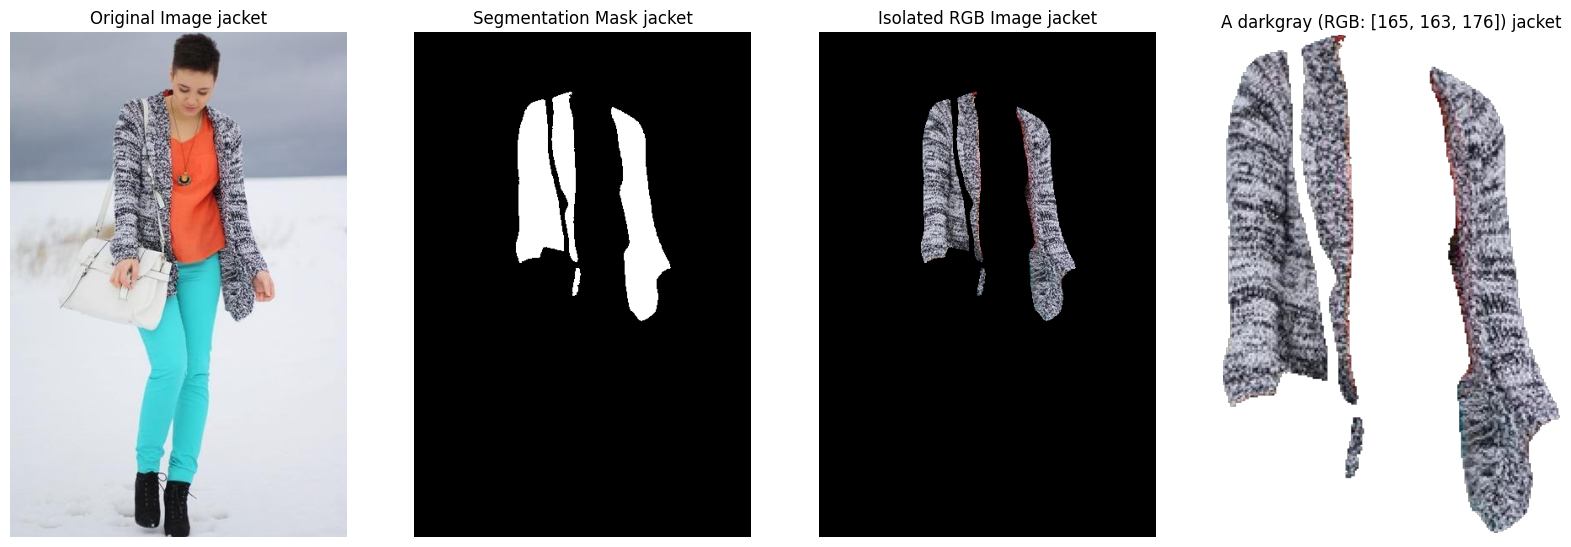

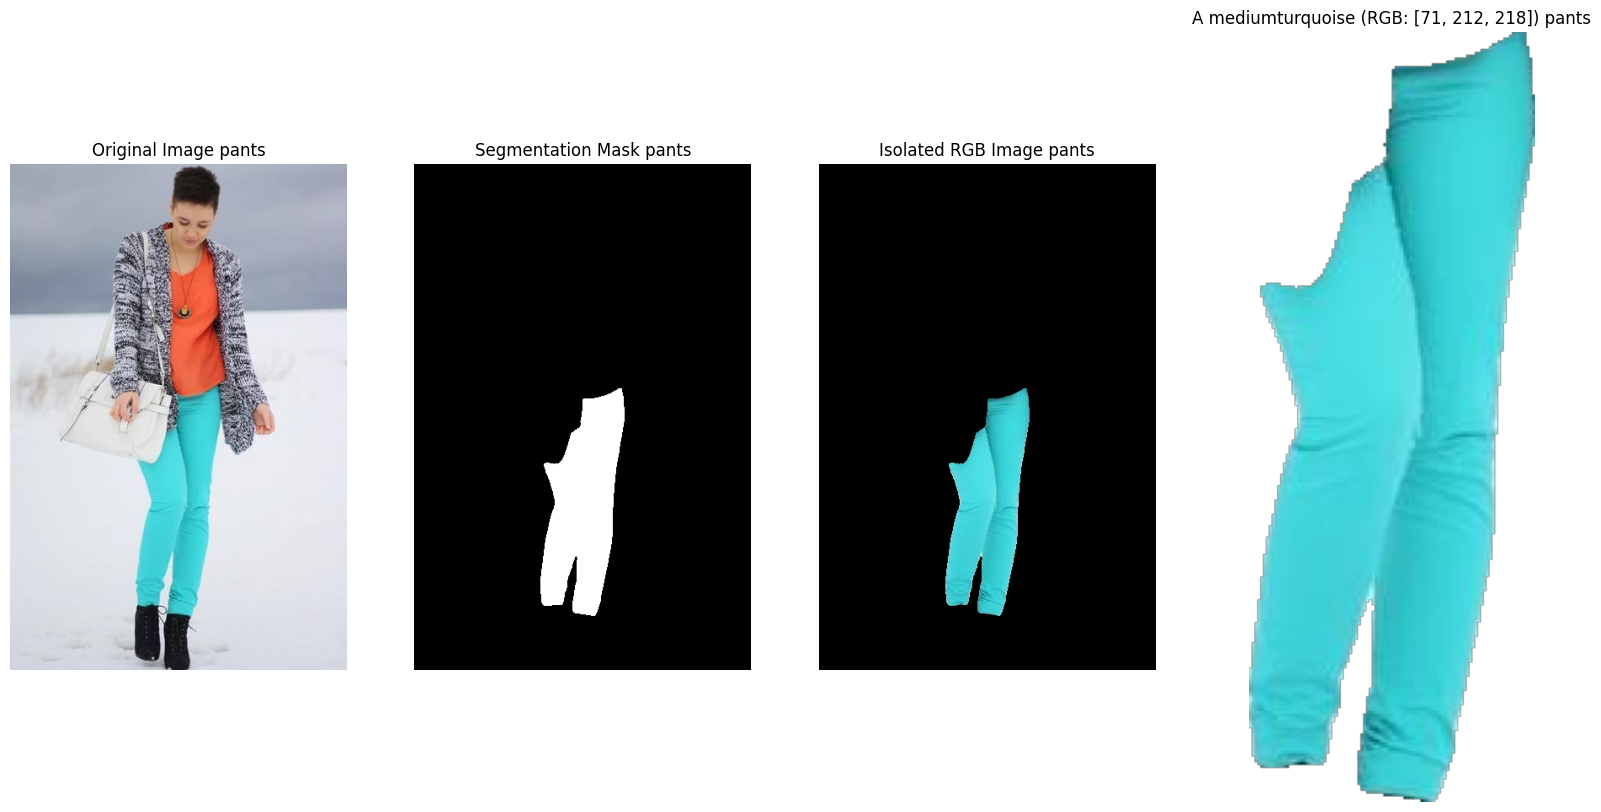

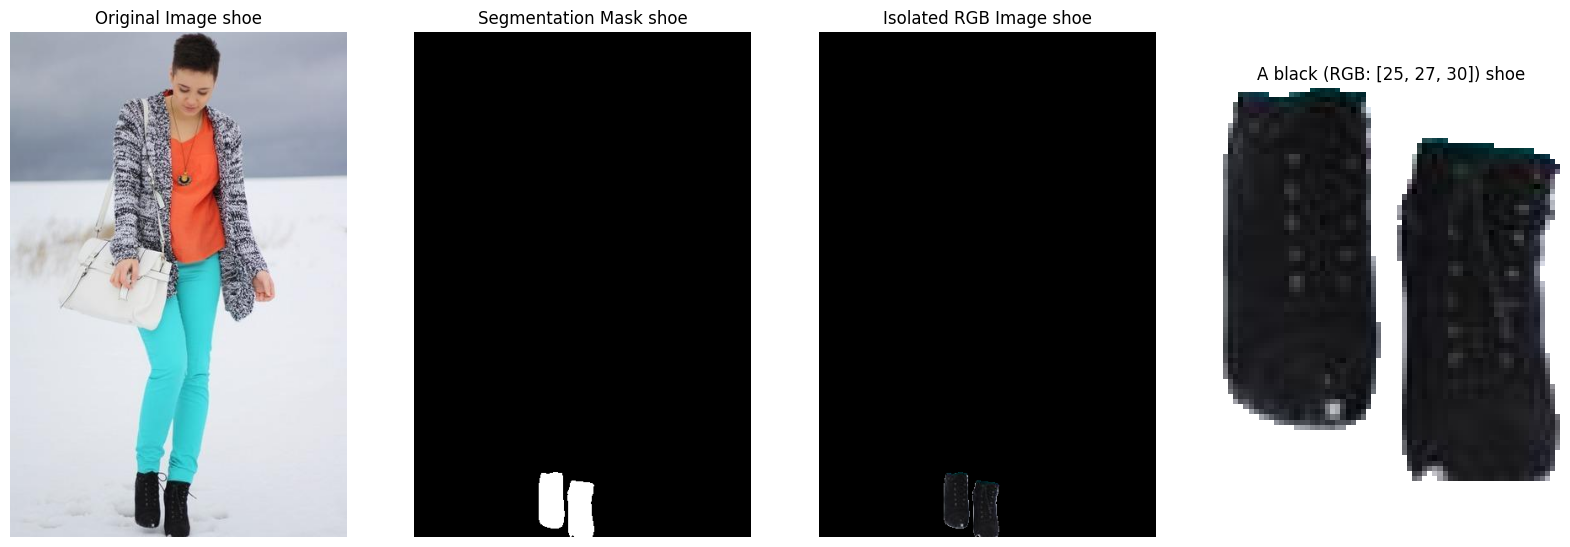

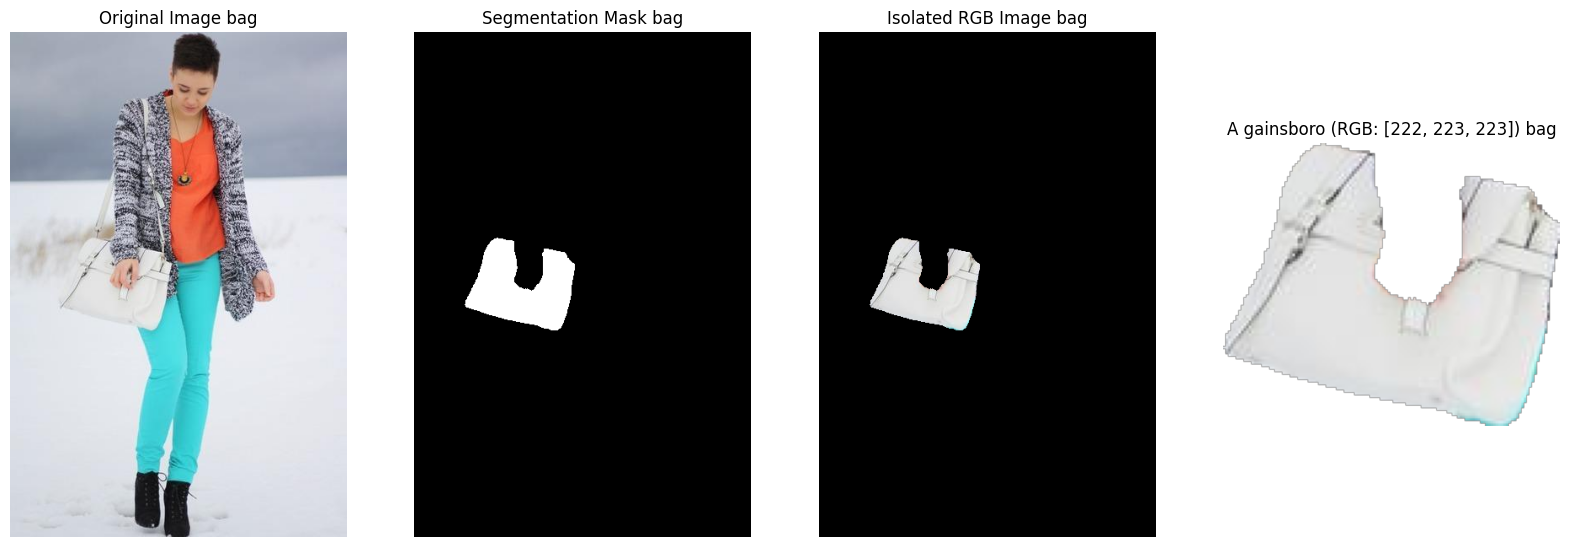

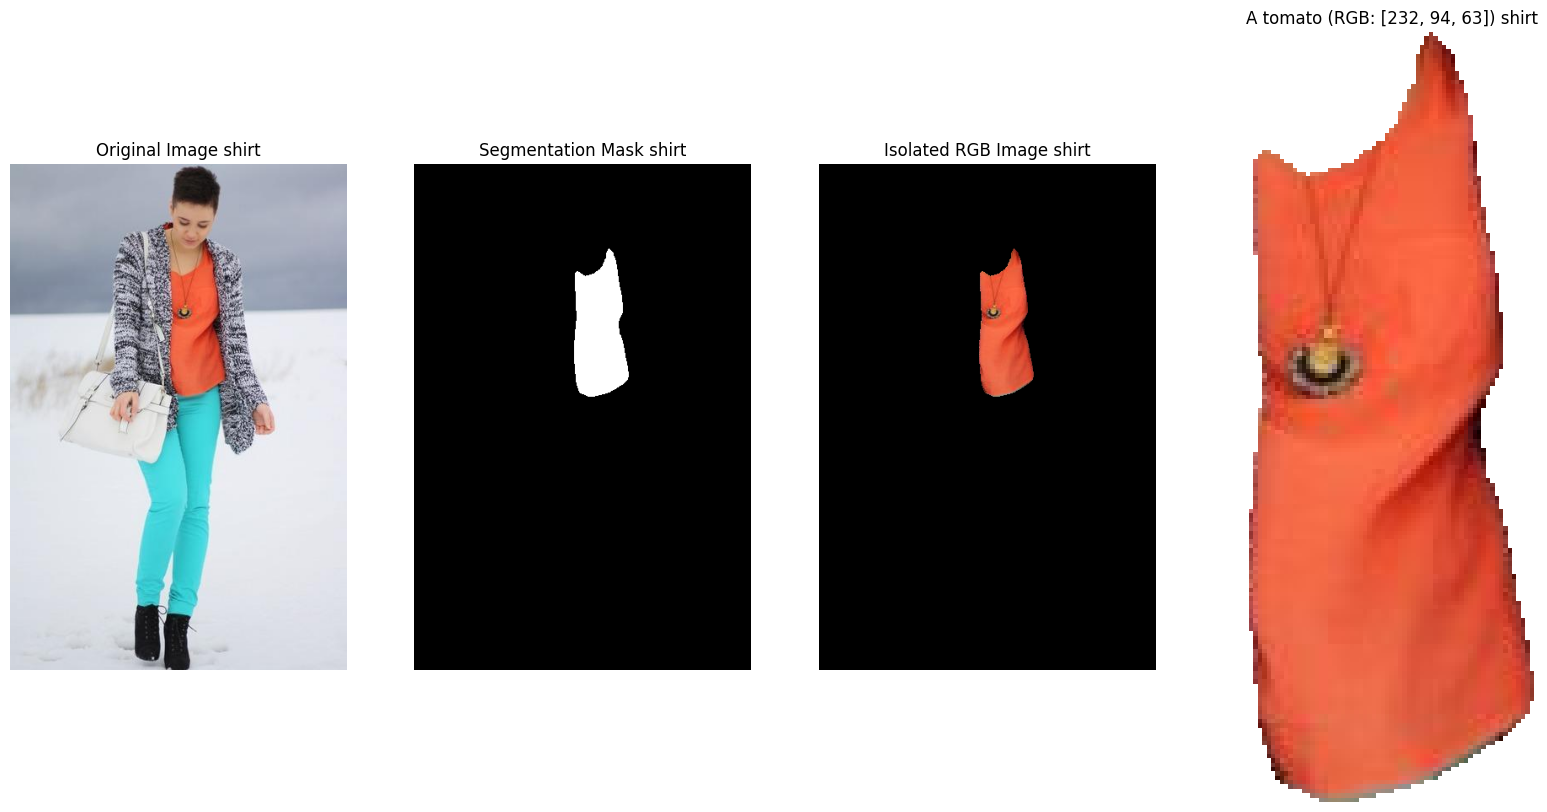

Segmentation complete.


In [6]:


import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from ultralytics import YOLO
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from torchvision.ops import nms
import random
from sklearn.cluster import KMeans




# Define the CSS3 colors and their RGB values
css3_colors = {
    'aliceblue': (240, 248, 255), 'antiquewhite': (250, 235, 215), 'aqua': (0, 255, 255),
    'aquamarine': (127, 255, 212), 'azure': (240, 255, 255), 'beige': (245, 245, 220),
    'bisque': (255, 228, 196), 'black': (0, 0, 0), 'blanchedalmond': (255, 235, 205),
    'blue': (0, 0, 255), 'blueviolet': (138, 43, 226), 'brown': (165, 42, 42),
    'burlywood': (222, 184, 135), 'cadetblue': (95, 158, 160), 'chartreuse': (127, 255, 0),
    'chocolate': (210, 105, 30), 'coral': (255, 127, 80), 'cornflowerblue': (100, 149, 237),
    'cornsilk': (255, 248, 220), 'crimson': (220, 20, 60), 'cyan': (0, 255, 255),
    'darkblue': (0, 0, 139), 'darkcyan': (0, 139, 139), 'darkgoldenrod': (184, 134, 11),
    'darkgray': (169, 169, 169), 'darkgreen': (0, 100, 0), 'darkkhaki': (189, 183, 107),
    'darkmagenta': (139, 0, 139), 'darkolivegreen': (85, 107, 47), 'darkorange': (255, 140, 0),
    'darkorchid': (153, 50, 204), 'darkred': (139, 0, 0), 'darksalmon': (233, 150, 122),
    'darkseagreen': (143, 188, 143), 'darkslateblue': (72, 61, 139), 'darkslategray': (47, 79, 79),
    'darkturquoise': (0, 206, 209), 'darkviolet': (148, 0, 211), 'deeppink': (255, 20, 147),
    'deepskyblue': (0, 191, 255), 'dimgray': (105, 105, 105), 'dodgerblue': (30, 144, 255),
    'firebrick': (178, 34, 34), 'floralwhite': (255, 250, 240), 'forestgreen': (34, 139, 34),
    'fuchsia': (255, 0, 255), 'gainsboro': (220, 220, 220), 'ghostwhite': (248, 248, 255),
    'gold': (255, 215, 0), 'goldenrod': (218, 165, 32), 'gray': (128, 128, 128),
    'green': (0, 128, 0), 'greenyellow': (173, 255, 47), 'honeydew': (240, 255, 240),
    'hotpink': (255, 105, 180), 'indianred': (205, 92, 92), 'indigo': (75, 0, 130),
    'ivory': (255, 255, 240), 'khaki': (240, 230, 140), 'lavender': (230, 230, 250),
    'lavenderblush': (255, 240, 245), 'lawngreen': (124, 252, 0), 'lemonchiffon': (255, 250, 205),
    'lightblue': (173, 216, 230), 'lightcoral': (240, 128, 128), 'lightcyan': (224, 255, 255),
    'lightgoldenrodyellow': (250, 250, 210), 'lightgreen': (144, 238, 144), 'lightgrey': (211, 211, 211),
    'lightpink': (255, 182, 193), 'lightsalmon': (255, 160, 122), 'lightseagreen': (32, 178, 170),
    'lightskyblue': (135, 206, 250), 'lightslategray': (119, 136, 153), 'lightsteelblue': (176, 196, 222),
    'lightyellow': (255, 255, 224), 'lime': (0, 255, 0), 'limegreen': (50, 205, 50),
    'linen': (250, 240, 230), 'magenta': (255, 0, 255), 'maroon': (128, 0, 0),
    'mediumaquamarine': (102, 205, 170), 'mediumblue': (0, 0, 205), 'mediumorchid': (186, 85, 211),
    'mediumpurple': (147, 112, 219), 'mediumseagreen': (60, 179, 113), 'mediumslateblue': (123, 104, 238),
    'mediumspringgreen': (0, 250, 154), 'mediumturquoise': (72, 209, 204), 'mediumvioletred': (199, 21, 133),
    'midnightblue': (25, 25, 112), 'mintcream': (245, 255, 250), 'mistyrose': (255, 228, 225),
    'moccasin': (255, 228, 181), 'navajowhite': (255, 222, 173), 'navy': (0, 0, 128),
    'oldlace': (253, 245, 230), 'olive': (128, 128, 0), 'olivedrab': (107, 142, 35),
    'orange': (255, 165, 0), 'orangered': (255, 69, 0), 'orchid': (218, 112, 214),
    'palegoldenrod': (238, 232, 170), 'palegreen': (152, 251, 152), 'paleturquoise': (175, 238, 238),
    'palevioletred': (219, 112, 147), 'papayawhip': (255, 239, 213), 'peachpuff': (255, 218, 185),
    'peru': (205, 133, 63), 'pink': (255, 192, 203), 'plum': (221, 160, 221),
    'powderblue': (176, 224, 230), 'purple': (128, 0, 128), 'rebeccapurple': (102, 51, 153),
    'red': (255, 0, 0), 'rosybrown': (188, 143, 143), 'royalblue': (65, 105, 225),
    'saddlebrown': (139, 69, 19), 'salmon': (250, 128, 114), 'sandybrown': (244, 164, 96),
    'seagreen': (46, 139, 87), 'seashell': (255, 245, 238), 'sienna': (160, 82, 45),
    'silver': (192, 192, 192), 'skyblue': (135, 206, 235), 'slateblue': (106, 90, 205),
    'slategray': (112, 128, 144), 'snow': (255, 250, 250), 'springgreen': (0, 255, 127),
    'steelblue': (70, 130, 180), 'tan': (210, 180, 140), 'teal': (0, 128, 128),
    'thistle': (216, 191, 216), 'tomato': (255, 99, 71), 'turquoise': (64, 224, 208),
    'violet': (238, 130, 238), 'wheat': (245, 222, 179), 'white': (255, 255, 255),
    'whitesmoke': (245, 245, 245), 'yellow': (255, 255, 0), 'yellowgreen': (154, 205, 50)
}




#def closest_color(requested_color):
def closest_color(requested_color):
    min_diff = float('inf')
    closest_color_name = None
    for color_name, rgb in css3_colors.items():
        diff = np.sqrt(np.sum((np.array(rgb) - np.array(requested_color)) ** 2))
        if diff < min_diff:
            min_diff = diff
            closest_color_name = color_name
    return closest_color_name, css3_colors[closest_color_name]

# Apply Non-Maximum Suppression (NMS)
def apply_nms(detected_items, iou_threshold=0.5):
    boxes = [item['coordinates'] for item in detected_items]
    scores = [item['confidence'] for item in detected_items]
    labels = [item['label'] for item in detected_items]

    boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
    scores_tensor = torch.tensor(scores, dtype=torch.float32)

    nms_indices = nms(boxes_tensor, scores_tensor, iou_threshold)

    nms_boxes = boxes_tensor[nms_indices].tolist()
    nms_scores = scores_tensor[nms_indices].tolist()
    nms_labels = [labels[i] for i in nms_indices]

    nms_items = []
    for i in range(len(nms_boxes)):
        nms_items.append({
            'label': nms_labels[i],
            'coordinates': nms_boxes[i],
            'confidence': nms_scores[i]
        })
    return nms_items

# Conflict resolution
def conflict_resolution(items):
    final_items = []
    items_dict = {}
    for i, item in enumerate(items):
        items_dict[item['label']] = {'confidence': item['confidence'], 'idx': i}

    conflicts = {
        'shirt': ['dress'],
        'pants': ['shorts', 'skirt'],
        'shorts': ['pants', 'skirt'],
        'skirt': ['pants', 'shorts'],
        'dress': ['shirt']
    }

    conflict_pairs = []
    for k in items_dict.keys():
        if k not in conflicts:
            final_items.append(items[items_dict[k]['idx']])
        else:
            flag = True
            for conflict in conflicts[k]:
                if conflict in items_dict.keys():
                    if set([k, conflict]) not in conflict_pairs:
                        conflict_pairs.append(set([k, conflict]))
                    flag = False
            if flag:
                final_items.append(items[items_dict[k]['idx']])

    for i, pair in enumerate(conflict_pairs):
        conflict_pairs[i] = list(pair)
    winners = []

    for pair in conflict_pairs:
        if pair[0] in winners:
            final_items.append(items[items_dict[pair[0]]['idx']])
        elif pair[1] in winners:
            final_items.append(items[items_dict[pair[1]]['idx']])
        elif items_dict[pair[0]]['confidence'] > items_dict[pair[1]]['confidence']:
            final_items.append(items[items_dict[pair[0]]['idx']])
            winners.append(pair[0])
        else:
            final_items.append(items[items_dict[pair[1]]['idx']])
            winners.append(pair[1])

    return final_items

# Process segmented patch and return the dominant color
def process_segmented_patch(image_rgba):
    pixels = image_rgba.reshape(-1, 4)
    pixels = pixels[pixels[:, 3] > 0]  # Consider only non-background pixels
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(pixels[:, :3])
    cluster_centers = kmeans.cluster_centers_.astype(int)
    dominant_color = cluster_centers[np.argmax(np.bincount(kmeans.labels_))]
    dominant_color_name, _ = closest_color(dominant_color)
    return dominant_color_name, dominant_color

# Detect and segment objects, then display them with description
def detect_and_segment_objects_with_description(base_path, sample_image_path, yolo_weights_path, sam2_weights_path, sam2_config_path):
    segmented_images_dir = os.path.join(base_path, "segmented_images")
    segmented_cropped_images_dir = os.path.join(base_path, "segmented_cropped")
    os.makedirs(segmented_images_dir, exist_ok=True)
    os.makedirs(segmented_cropped_images_dir, exist_ok=True)

    mask_predictor = SAM2ImagePredictor(build_sam2(sam2_config_path, sam2_weights_path))
    model = YOLO(yolo_weights_path)

    image = Image.open(sample_image_path).convert('RGB')
    image_rgb = np.array(image)
    image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)

    results = model(sample_image_path)

    detected_items = []
    for result in results:
        boxes = result.boxes
        for box in boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            confidence = box.conf[0].item()
            class_id = int(box.cls[0])
            label = model.names[class_id]

            detected_items.append({
                'label': label,
                'coordinates': (x1, y1, x2, y2),
                'confidence': confidence
            })

    resolved_items = apply_nms(detected_items)
    resolved_items = conflict_resolution(resolved_items)

    predicted_boxes = np.array([item['coordinates'] for item in resolved_items])
    mask_predictor.set_image(image_bgr)

    masks, _, _ = mask_predictor.predict(
        point_coords=None,
        point_labels=None,
        box=predicted_boxes[None, :],
        multimask_output=False,
    )

    labels = [item['label'] for item in resolved_items]

    for i, mask in enumerate(masks):
        mask = mask[0].astype(np.uint8)

        isolated_rgb_image = image_rgb * mask[:, :, np.newaxis]
        isolated_rgb_filename = os.path.join(segmented_images_dir, f"{labels[i]}_isolated_rgb_{i}.png")
        isolated_rgb_image_pil = Image.fromarray(isolated_rgb_image)
        isolated_rgb_image_pil.save(isolated_rgb_filename)

        coords = np.column_stack(np.where(mask > 0))
        if coords.size == 0:
            continue
        y1, x1 = coords.min(axis=0)
        y2, x2 = coords.max(axis=0)

        isolated_cropped_image = isolated_rgb_image[y1:y2+1, x1:x2+1]
        isolated_cropped_image_rgba = np.zeros((y2 - y1 + 1, x2 - x1 + 1, 4), dtype=np.uint8)
        isolated_cropped_image_rgba[..., :3] = isolated_cropped_image
        isolated_cropped_image_rgba[..., 3] = mask[y1:y2+1, x1:x2+1] * 255

        isolated_cropped_filename = os.path.join(segmented_cropped_images_dir, f"{labels[i]}_isolated_rgba_{i}.png")
        isolated_cropped_image_rgba_pil = Image.fromarray(isolated_cropped_image_rgba, 'RGBA')
        isolated_cropped_image_rgba_pil.save(isolated_cropped_filename)

        dominant_color_name, dominant_color = process_segmented_patch(isolated_cropped_image_rgba)

        # Visualize images and descriptions
        plt.figure(figsize=(20, 10))

        plt.subplot(1, 4, 1)
        plt.imshow(image_rgb)
        plt.title(f"Original Image {labels[i]}")
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f"Segmentation Mask {labels[i]}")
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(isolated_rgb_image_pil)
        plt.title(f"Isolated RGB Image {labels[i]}")
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(isolated_cropped_image_rgba_pil)
        plt.title(f"A {dominant_color_name} (RGB: {dominant_color.tolist()}) {labels[i]}")
        plt.axis('off')

        plt.show()

    print("Segmentation complete.")

base_path = '/home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering'
jpeg_images_path = "JPEGImages"
train_image_path = os.path.join(jpeg_images_path, "train")

runs_path = os.path.join(base_path, 'runs', 'detect')
weights_save_path = os.path.join(runs_path, 'train', 'weights')
yolo_best_weights_path = os.path.join(weights_save_path, "best.pt")

# Paths for SAMv2
sam2_weights_path = os.path.join(base_path, "segment-anything-2/checkpoints/sam2_hiera_large.pt")
sam2_config_path = "sam2_hiera_l.yaml"

# Select a sample image
sample_image_path = os.path.join(train_image_path, "191571.jpg")  # Replace with your image

# Perform detection and segmentation
detect_and_segment_objects_with_description(base_path, sample_image_path, yolo_best_weights_path, sam2_weights_path, sam2_config_path)

### 7.1.  Calculate the Optimal Number of Clusters with Elbow Method


image 1/1 /home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/colorful_fashion_dataset/JPEGImages/train/12877.jpg: 640x448 1 jacket, 1 dress, 1 bag, 1 shoe, 16.1ms
Speed: 1.5ms preprocess, 16.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/colorful_fashion_dataset/JPEGImages/val/104565.jpg: 640x448 1 shirt, 1 pants, 1 shoe, 20.7ms
Speed: 1.5ms preprocess, 20.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/colorful_fashion_dataset/JPEGImages/val/18000.jpg: 640x448 1 jacket, 1 shirt, 1 pants, 1 bag, 1 shoe, 19.6ms
Speed: 1.5ms preprocess, 19.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/colorful_fashion_dataset/JPEGImages/test/18650.jpg: 640x448 1 jacket, 1 shirt, 1 shorts, 1 shoe, 18.0

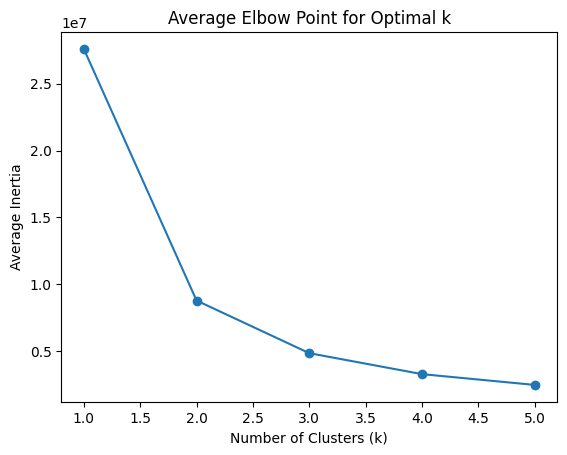

Segmentation and average elbow point calculation complete.


In [8]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
import random
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamPredictor
from torchvision.ops import nms


def kmeans_clustering(image, n_clusters):
    pixels = image.reshape(-1, 4)
    pixels = pixels[pixels[:, 3] > 0]  # Only consider non-transparent pixels
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(pixels[:, :3])
    inertia = kmeans.inertia_
    return inertia

def calculate_average_elbow_point(all_segmented_images):
    max_k = 5
    all_inertias = []

    for image in all_segmented_images:
        inertias = []
        for k in range(1, max_k + 1):
            inertia = kmeans_clustering(image, n_clusters=k)
            inertias.append(inertia)
        all_inertias.append(inertias)

    # Convert to numpy array to easily compute the mean across all images
    all_inertias = np.array(all_inertias)
    print(f" all inertias:{all_inertias}")
    mean_inertias = np.mean(all_inertias, axis=0)

    # Plotting the average elbow point
    plt.figure()
    plt.plot(range(1, max_k + 1), mean_inertias, marker='o')
    plt.title('Average Elbow Point for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Average Inertia')
    plt.show()

class FashionDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image_path, image

# Define Non-Maximum Suppression (NMS) function
def apply_nms(detected_items, iou_threshold=0.5):
    boxes = [item['coordinates'] for item in detected_items]
    scores = [item['confidence'] for item in detected_items]
    labels = [item['label'] for item in detected_items]

    boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
    scores_tensor = torch.tensor(scores, dtype=torch.float32)

    # Apply NMS
    nms_indices = nms(boxes_tensor, scores_tensor, iou_threshold)

    # Filter boxes, scores, and labels based on NMS output
    nms_boxes = boxes_tensor[nms_indices].tolist()
    nms_scores = scores_tensor[nms_indices].tolist()
    nms_labels = [labels[i] for i in nms_indices]

    # Reformat the filtered results into the detected_items structure
    nms_items = []
    for i in range(len(nms_boxes)):
        nms_items.append({
            'label': nms_labels[i],
            'coordinates': nms_boxes[i],
            'confidence': nms_scores[i]
        })
    return nms_items

def detect_and_segment_batch(base_path, image_paths, yolo_weights_path, sam_model_path, batch_size=4):
    sam = sam_model_registry["vit_h"](checkpoint=sam_model_path).to(device=torch.device('cuda:0'))
    mask_predictor = SamPredictor(sam)
    model = YOLO(yolo_weights_path)
    transform = transforms.Compose([transforms.ToTensor()])

    # Randomly sample 200 images
    if len(image_paths) > 200:
        sampled_image_paths = random.sample(image_paths, 200)
    else:
        sampled_image_paths = image_paths

    dataset = FashionDataset(sampled_image_paths, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    all_segmented_images = []

    for batch in dataloader:
        image_paths_batch, images_batch = batch
        images_batch = images_batch.to('cuda')

        for i, image in enumerate(images_batch):
            sample_image_path = image_paths_batch[i]
            image_pil = transforms.ToPILImage()(image.cpu())
            image_rgb = np.array(image_pil)
            image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)

            # Perform object detection with YOLO
            results = model(sample_image_path)

            # Collect detected items
            detected_items = []
            for result in results:
                boxes = result.boxes
                for box in boxes:
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    confidence = box.conf[0].item()
                    class_id = int(box.cls[0])
                    label = model.names[class_id]

                    detected_items.append({
                        'label': label,
                        'coordinates': (x1, y1, x2, y2),
                        'confidence': confidence
                    })

            # Apply Non-Maximum Suppression (NMS)
            resolved_items = apply_nms(detected_items, iou_threshold=0.5)

            predicted_boxes = []
            for item in resolved_items:
                x1, y1, x2, y2 = item['coordinates']
                predicted_boxes.append([x1, y1, x2, y2])

            predicted_boxes_tensor = torch.tensor(predicted_boxes, dtype=torch.float32).to('cuda')
            transformed_boxes = mask_predictor.transform.apply_boxes_torch(predicted_boxes_tensor, image_bgr.shape[:2])

            mask_predictor.set_image(image_bgr)
            masks, _, _ = mask_predictor.predict_torch(
                boxes=transformed_boxes.to('cuda'),
                multimask_output=False,
                point_coords=None,
                point_labels=None
            )

            for j, mask in enumerate(masks):
                mask = mask[0].cpu().numpy().astype(np.uint8)

                isolated_image = image_rgb * mask[:, :, np.newaxis]

                coords = np.column_stack(np.where(mask > 0))
                if coords.size == 0:
                    print(f"No object found for mask {j}")
                    continue
                y1, x1 = coords.min(axis=0)
                y2, x2 = coords.max(axis=0)

                isolated_cropped_image = isolated_image[y1:y2+1, x1:x2+1]
                isolated_cropped_image_rgba = np.zeros((y2 - y1 + 1, x2 - x1 + 1, 4), dtype=np.uint8)
                isolated_cropped_image_rgba[..., :3] = isolated_cropped_image
                isolated_cropped_image_rgba[..., 3] = mask[y1:y2+1, x1:x2+1] * 255

                # Store the segmented cropped image for elbow calculation
                all_segmented_images.append(isolated_cropped_image_rgba)

        torch.cuda.empty_cache()

    # Calculate the average elbow point for all segmented images
    calculate_average_elbow_point(all_segmented_images)

    print("Segmentation and average elbow point calculation complete.")

# Example usage:
base_path = '/home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering'
annotations_path = "Annotations"
annotations_txt_path = "Annotations_txt"
image_sets_path = "ImageSets/Main"
jpeg_images_path = "JPEGImages"

train_image_path = os.path.join(jpeg_images_path, "train")
val_image_path = os.path.join(jpeg_images_path, "val")
test_image_path = os.path.join(jpeg_images_path, "test")

# Load the trained model
runs_path = os.path.join(base_path, 'runs', 'detect')
weights_save_path = os.path.join(runs_path, 'train','weights')
yolo_best_weights_path = os.path.join(weights_save_path, "best.pt")
sam_model_path = os.path.join(base_path, "models","sam_vit_h_4b8939.pth")

train_images = [os.path.join(train_image_path, img) for img in os.listdir(train_image_path) if img.endswith(('.jpg', '.jpeg', '.png'))]
val_images = [os.path.join(val_image_path, img) for img in os.listdir(val_image_path) if img.endswith(('.jpg', '.jpeg', '.png'))]
test_images = [os.path.join(test_image_path, img) for img in os.listdir(test_image_path) if img.endswith(('.jpg', '.jpeg', '.png'))]

all_image_paths = train_images + val_images + test_images

detect_and_segment_batch(base_path, all_image_paths, yolo_best_weights_path, sam_model_path, batch_size=10)

When extracting colors from a clothing item using clustering techniques like K-means, we need to decide how many clusters (k) to create. Each cluster corresponds

 to a different dominant color.The Elbow Method is used in the process of finding dominant colors to determine the optimal number of color clusters (k) in a given

 image. This helps in identifying the most representative colors present in a clothing item.

 the result after applying elboe method:

 The "elbow point" is where the rate of decrease in inertia significantly slows down, indicating the point beyond which adding more clusters does not improve the 
 
 clustering significantly.

In the given graph, the "elbow" is observed at k = 2. This means that choosing 2 clusters is optimal because increasing beyond 2 does not substantially decrease

 the inertia.

### 7.2. Quality of clustering with Silhouette Score

/home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/segment-anything-2/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()



image 1/1 /home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/JPEGImages/train/133533.jpg: 640x448 1 jacket, 2 shirts, 1 skirt, 1 shoe, 41.8ms
Speed: 3.2ms preprocess, 41.8ms inference, 141.3ms postprocess per image at shape (1, 3, 640, 448)
Image: JPEGImages/train/133533.jpg processed.
Image: JPEGImages/train/133533.jpg processed.
Image: JPEGImages/train/133533.jpg processed.
Image: JPEGImages/train/133533.jpg processed.

image 1/1 /home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/JPEGImages/test/70633.jpg: 640x448 2 sunglasss, 1 jacket, 1 shirt, 1 pants, 1 shoe, 17.9ms
Speed: 1.6ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)
Image: JPEGImages/test/70633.jpg processed.
Image: JPEGImages/test/70633.jpg processed.
Image: JPEGImages/test/70633.jpg processed.
Image: JPEGImages/test/70633.jpg processed.
Image: JPEGImages/test/70633.jpg processed.

image 1/1 /home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/

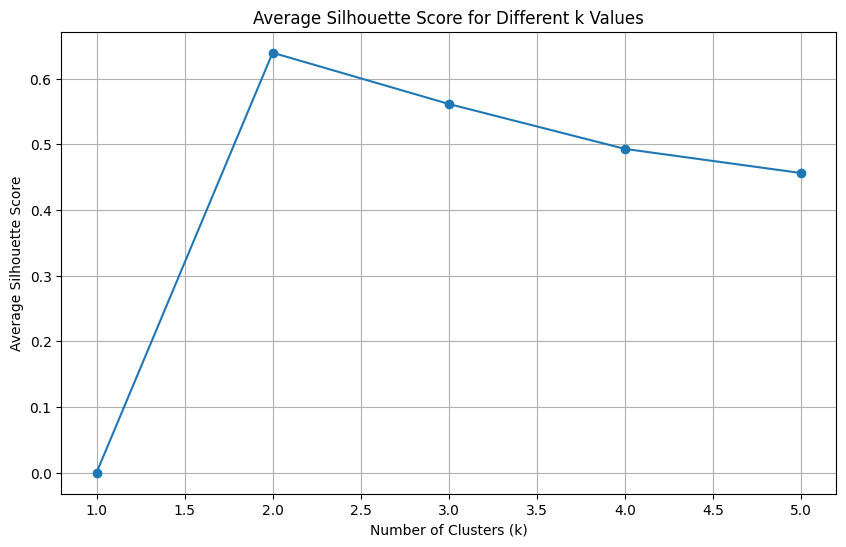

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import torch
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from ultralytics import YOLO
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from torchvision.ops import nms
from torch.utils.data import DataLoader, Dataset
import random
from torchvision import transforms

torch.cuda.empty_cache()

# Function to apply Non-Maximum Suppression (NMS)
def apply_nms(detected_items, iou_threshold=0.5):
    boxes = [item['coordinates'] for item in detected_items]
    scores = [item['confidence'] for item in detected_items]
    labels = [item['label'] for item in detected_items]

    boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
    scores_tensor = torch.tensor(scores, dtype=torch.float32)

    # Apply NMS
    nms_indices = nms(boxes_tensor, scores_tensor, iou_threshold)

    # Filter boxes, scores, and labels based on NMS output
    nms_boxes = boxes_tensor[nms_indices].tolist()
    nms_scores = scores_tensor[nms_indices].tolist()
    nms_labels = [labels[i] for i in nms_indices]

    # Reformat the filtered results into the detected_items structure
    nms_items = []
    for i in range(len(nms_boxes)):
        nms_items.append({
            'label': nms_labels[i],
            'coordinates': nms_boxes[i],
            'confidence': nms_scores[i]
        })
    return nms_items

# Function for conflict resolution
def conflict_resolution(items):
    final_items = []
    items_dict = {}
    for i, item in enumerate(items):
        items_dict[item['label']] = {'confidence': item['confidence'], 'idx': i}

    conflicts = {
        'shirt': ['dress'],
        'pants': ['shorts', 'skirt'],
        'shorts': ['pants', 'skirt'],
        'skirt': ['pants', 'shorts'],
        'dress': ['shirt']
    }

    conflict_pairs = []
    for k in items_dict.keys():
        if k not in conflicts:
            final_items.append(items[items_dict[k]['idx']])
        else:
            flag = True
            for conflict in conflicts[k]:
                if conflict in items_dict.keys():
                    if set([k, conflict]) not in conflict_pairs:
                        conflict_pairs.append(set([k, conflict]))
                    flag = False
            if flag:
                final_items.append(items[items_dict[k]['idx']])

    for i, pair in enumerate(conflict_pairs):
        conflict_pairs[i] = list(pair)
    winners = []

    for pair in conflict_pairs:
        if pair[0] in winners:
            final_items.append(items[items_dict[pair[0]]['idx']])
        elif pair[1] in winners:
            final_items.append(items[items_dict[pair[1]]['idx']])
        elif items_dict[pair[0]]['confidence'] > items_dict[pair[1]]['confidence']:
            final_items.append(items[items_dict[pair[0]]['idx']])
            winners.append(pair[0])
        else:
            final_items.append(items[items_dict[pair[1]]['idx']])
            winners.append(pair[1])
    return final_items

# Function for K-means clustering on a single image and calculating silhouette score
def kmeans_clustering(image, n_clusters):
    pixels = image.reshape(-1, 4)
    pixels = pixels[pixels[:, 3] > 0]  # Only consider non-transparent pixels
    if len(pixels) < n_clusters:
        return 0

    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(pixels[:, :3])
    labels = kmeans.labels_

    if len(set(labels)) > 1:  # Silhouette score requires at least 2 clusters
        silhouette_avg = silhouette_score(pixels[:, :3], labels)
    else:
        silhouette_avg = 0  # No silhouette score if there's only one cluster

    return silhouette_avg

# Dataset class for loading and processing images
class FashionDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image_path, image

# Function to detect and segment objects in batches
def detect_and_segment_batch(base_path, image_paths, yolo_weights_path, sam2_weights_path, sam2_config_path, batch_size=4, k_values=[1, 2, 3, 4, 5]):
    # Load the SAMv2 model
    mask_predictor = SAM2ImagePredictor(build_sam2(sam2_config_path, sam2_weights_path))
    # Load the YOLO model
    model = YOLO(yolo_weights_path)
    transform = transforms.Compose([transforms.ToTensor()])

    # Randomly sample 10 images
    if len(image_paths) > 10:
        sampled_image_paths = random.sample(image_paths, 10)
    else:
        sampled_image_paths = image_paths

    dataset = FashionDataset(sampled_image_paths, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    silhouette_scores = {k: 0 for k in k_values}  # Initialize dictionary to hold scores for each k
    total_images = 0  # Counter for the number of processed images

    for batch in dataloader:
        image_paths_batch, images_batch = batch
        images_batch = images_batch.to('cuda')

        for i, image in enumerate(images_batch):
            sample_image_path = image_paths_batch[i]
            image_rgb = np.array(transforms.ToPILImage()(image.cpu()))
            image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)

            # Perform object detection with YOLO
            results = model(sample_image_path)

            # Collect detected items
            detected_items = []
            for result in results:
                boxes = result.boxes
                for box in boxes:
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    confidence = box.conf[0].item()
                    class_id = int(box.cls[0])
                    label = model.names[class_id]

                    detected_items.append({
                        'label': label,
                        'coordinates': (x1, y1, x2, y2),
                        'confidence': confidence
                    })

            # Apply NMS and conflict resolution
            nms_filtered_items = apply_nms(detected_items, iou_threshold=0.5)
            resolved_items = conflict_resolution(nms_filtered_items)

            predicted_boxes = []
            for item in resolved_items:
                x1, y1, x2, y2 = item['coordinates']
                predicted_boxes.append([x1, y1, x2, y2])

            # Prepare boxes for SAMv2 segmentation
            predicted_boxes = np.array(predicted_boxes)
            
            # Set the image for SAMv2 to generate segmentation masks
            mask_predictor.set_image(image_bgr)

            # Generate segmentation masks with SAMv2
            masks, _, _ = mask_predictor.predict(
                point_coords=None,
                point_labels=None,
                box=predicted_boxes[None, :],
                multimask_output=False,
            )

            for j, mask in enumerate(masks):
                mask = mask[0].astype(np.uint8)

                isolated_image = image_rgb * mask[:, :, np.newaxis]

                coords = np.column_stack(np.where(mask > 0))
                if coords.size == 0:
                    print(f"No object found for mask {j}")
                    continue
                y1, x1 = coords.min(axis=0)
                y2, x2 = coords.max(axis=0)

                isolated_cropped_image = isolated_image[y1:y2+1, x1:x2+1]
                isolated_cropped_image_rgba = np.zeros((y2 - y1 + 1, x2 - x1 + 1, 4), dtype=np.uint8)
                isolated_cropped_image_rgba[..., :3] = isolated_cropped_image
                isolated_cropped_image_rgba[..., 3] = mask[y1:y2+1, x1:x2+1] * 255

                # Calculate silhouette score for the segmented cropped image for each k
                for k in k_values:
                    silhouette_avg = kmeans_clustering(isolated_cropped_image_rgba, n_clusters=k)
                    silhouette_scores[k] += silhouette_avg

                total_images += 1
                print(f"Image: {sample_image_path} processed.")

    # Calculate and print the average silhouette score for each k
    if total_images > 0:
        for k in k_values:
            silhouette_scores[k] /= total_images
            print(f"Average Silhouette Score for k={k}: {silhouette_scores[k]:.4f}")
    else:
        print("No images were processed.")

    torch.cuda.empty_cache()

    print("Segmentation and silhouette score calculation complete.")
    return silhouette_scores

# Example usage:
base_path = '/home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering'
annotations_path = "Annotations"
annotations_txt_path = "Annotations_txt"
image_sets_path = "ImageSets/Main"
jpeg_images_path = "JPEGImages"

train_image_path = os.path.join(jpeg_images_path, "train")
val_image_path = os.path.join(jpeg_images_path, "val")
test_image_path = os.path.join(jpeg_images_path, "test")

# Load the trained model
runs_path = os.path.join(base_path, 'runs', 'detect')
weights_save_path = os.path.join(runs_path, 'train','weights')
yolo_best_weights_path = os.path.join(weights_save_path, "best.pt")

# Paths for SAMv2
sam2_weights_path = os.path.join(base_path, "segment-anything-2/checkpoints/sam2_hiera_large.pt")
sam2_config_path = "sam2_hiera_l.yaml"

# Gather all image paths
train_images = [os.path.join(train_image_path, img) for img in os.listdir(train_image_path) if img.endswith(('.jpg', '.jpeg', '.png'))]
val_images = [os.path.join(val_image_path, img) for img in os.listdir(val_image_path) if img.endswith(('.jpg', '.jpeg', '.png'))]
test_images = [os.path.join(test_image_path, img) for img in os.listdir(test_image_path) if img.endswith(('.jpg', '.jpeg', '.png'))]

all_image_paths = train_images + val_images + test_images

# Sample 10 images
sampled_image_paths = random.sample(all_image_paths, 7)

# Define k values to test
k_values = [1, 2, 3, 4, 5]

# Process and calculate silhouette score for the sampled images with different k values
silhouette_scores = detect_and_segment_batch(base_path, sampled_image_paths, yolo_best_weights_path, sam2_weights_path, sam2_config_path, batch_size=10, k_values=k_values)

# Plotting the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, [silhouette_scores[k] for k in k_values], marker='o')
plt.title('Average Silhouette Score for Different k Values')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.grid(True)
plt.show()

 based on the elboe method we can see that from k= 2 the wcss decrease slightly which means with more clusters we can not necessarily get better clustering

 The Silhouette Score is a metric used to evaluate the quality of clustering. It measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The score ranges from -1 to 1, where:

- +1 indicates that the sample is far away from the neighboring clusters, suggesting that the sample is correctly clustered.

- 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters, suggesting that the sample could be assigned to either cluster.

- -1 indicates that the sample is closer to a neighboring cluster than to its own cluster, suggesting that the sample has been incorrectly clustered.

Calculating the Silhouette Score:
The silhouette score for a single sample is calculated as:

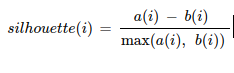

we evaluate the quality of clustering also with another method called Silhouette Score and for each item of clothes in each image andfor 100 samples from data we calculate silhouette scores for k = 2, 3, 4 to see in which number of cluster the silhouette score has is the best score.which shows the quality of clustering .then we can validate elbow method and we can decide for which number of cluster get the best clusters colors and then get the dominant color from them.

Where:

a(i) is the average distance between the sample i and all other points in the same cluster (cohesion).

b(i) is the average distance between the sample i and all points in the nearest cluster that the sample is not a part of (separation).

The overall Silhouette Score for a clustering solution is the average of the silhouette scores of all samples.

### our End to End Pipeline for obtaining short description for (type of clothing items and color) all clothing items for 100 sample images 

In [1]:

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from ultralytics import YOLO
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from torchvision.ops import nms
import random
from sklearn.cluster import KMeans


css3_colors = {
    'aliceblue': (240, 248, 255), 'antiquewhite': (250, 235, 215), 'aqua': (0, 255, 255),
    'aquamarine': (127, 255, 212), 'azure': (240, 255, 255), 'beige': (245, 245, 220),
    'bisque': (255, 228, 196), 'black': (0, 0, 0), 'blanchedalmond': (255, 235, 205),
    'blue': (0, 0, 255), 'blueviolet': (138, 43, 226), 'brown': (165, 42, 42),
    'burlywood': (222, 184, 135), 'cadetblue': (95, 158, 160), 'chartreuse': (127, 255, 0),
    'chocolate': (210, 105, 30), 'coral': (255, 127, 80), 'cornflowerblue': (100, 149, 237),
    'cornsilk': (255, 248, 220), 'crimson': (220, 20, 60), 'cyan': (0, 255, 255),
    'darkblue': (0, 0, 139), 'darkcyan': (0, 139, 139), 'darkgoldenrod': (184, 134, 11),
    'darkgray': (169, 169, 169), 'darkgreen': (0, 100, 0), 'darkkhaki': (189, 183, 107),
    'darkmagenta': (139, 0, 139), 'darkolivegreen': (85, 107, 47), 'darkorange': (255, 140, 0),
    'darkorchid': (153, 50, 204), 'darkred': (139, 0, 0), 'darksalmon': (233, 150, 122),
    'darkseagreen': (143, 188, 143), 'darkslateblue': (72, 61, 139), 'darkslategray': (47, 79, 79),
    'darkturquoise': (0, 206, 209), 'darkviolet': (148, 0, 211), 'deeppink': (255, 20, 147),
    'deepskyblue': (0, 191, 255), 'dimgray': (105, 105, 105), 'dodgerblue': (30, 144, 255),
    'firebrick': (178, 34, 34), 'floralwhite': (255, 250, 240), 'forestgreen': (34, 139, 34),
    'fuchsia': (255, 0, 255), 'gainsboro': (220, 220, 220), 'ghostwhite': (248, 248, 255),
    'gold': (255, 215, 0), 'goldenrod': (218, 165, 32), 'gray': (128, 128, 128),
    'green': (0, 128, 0), 'greenyellow': (173, 255, 47), 'honeydew': (240, 255, 240),
    'hotpink': (255, 105, 180), 'indianred': (205, 92, 92), 'indigo': (75, 0, 130),
    'ivory': (255, 255, 240), 'khaki': (240, 230, 140), 'lavender': (230, 230, 250),
    'lavenderblush': (255, 240, 245), 'lawngreen': (124, 252, 0), 'lemonchiffon': (255, 250, 205),
    'lightblue': (173, 216, 230), 'lightcoral': (240, 128, 128), 'lightcyan': (224, 255, 255),
    'lightgoldenrodyellow': (250, 250, 210), 'lightgreen': (144, 238, 144), 'lightgrey': (211, 211, 211),
    'lightpink': (255, 182, 193), 'lightsalmon': (255, 160, 122), 'lightseagreen': (32, 178, 170),
    'lightskyblue': (135, 206, 250), 'lightslategray': (119, 136, 153), 'lightsteelblue': (176, 196, 222),
    'lightyellow': (255, 255, 224), 'lime': (0, 255, 0), 'limegreen': (50, 205, 50),
    'linen': (250, 240, 230), 'magenta': (255, 0, 255), 'maroon': (128, 0, 0),
    'mediumaquamarine': (102, 205, 170), 'mediumblue': (0, 0, 205), 'mediumorchid': (186, 85, 211),
    'mediumpurple': (147, 112, 219), 'mediumseagreen': (60, 179, 113), 'mediumslateblue': (123, 104, 238),
    'mediumspringgreen': (0, 250, 154), 'mediumturquoise': (72, 209, 204), 'mediumvioletred': (199, 21, 133),
    'midnightblue': (25, 25, 112), 'mintcream': (245, 255, 250), 'mistyrose': (255, 228, 225),
    'moccasin': (255, 228, 181), 'navajowhite': (255, 222, 173), 'navy': (0, 0, 128),
    'oldlace': (253, 245, 230), 'olive': (128, 128, 0), 'olivedrab': (107, 142, 35),
    'orange': (255, 165, 0), 'orangered': (255, 69, 0), 'orchid': (218, 112, 214),
    'palegoldenrod': (238, 232, 170), 'palegreen': (152, 251, 152), 'paleturquoise': (175, 238, 238),
    'palevioletred': (219, 112, 147), 'papayawhip': (255, 239, 213), 'peachpuff': (255, 218, 185),
    'peru': (205, 133, 63), 'pink': (255, 192, 203), 'plum': (221, 160, 221),
    'powderblue': (176, 224, 230), 'purple': (128, 0, 128), 'rebeccapurple': (102, 51, 153),
    'red': (255, 0, 0), 'rosybrown': (188, 143, 143), 'royalblue': (65, 105, 225),
    'saddlebrown': (139, 69, 19), 'salmon': (250, 128, 114), 'sandybrown': (244, 164, 96),
    'seagreen': (46, 139, 87), 'seashell': (255, 245, 238), 'sienna': (160, 82, 45),
    'silver': (192, 192, 192), 'skyblue': (135, 206, 235), 'slateblue': (106, 90, 205),
    'slategray': (112, 128, 144), 'snow': (255, 250, 250), 'springgreen': (0, 255, 127),
    'silver': (192, 192, 192), 'skyblue': (135, 206, 235), 'slateblue': (106, 90, 205),
    'silver': (192, 192, 192), 'skyblue': (135, 206, 235), 'slateblue': (106, 90, 205),
    'slategray': (112, 128, 144), 'snow': (255, 250, 250), 'springgreen': (0, 255, 127),
    'steelblue': (70, 130, 180), 'tan': (210, 180, 140), 'teal': (0, 128, 128),
    'thistle': (216, 191, 216), 'tomato': (255, 99, 71), 'turquoise': (64, 224, 208),
    'violet': (238, 130, 238), 'wheat': (245, 222, 179), 'white': (255, 255, 255),
    'whitesmoke': (245, 245, 245), 'yellow': (255, 255, 0), 'yellowgreen': (154, 205, 50)
}









# Function to find the closest color name from the CSS3 color dictionary
def closest_color(requested_color):
    min_diff = float('inf')
    closest_color_name = None
    for color_name, rgb in css3_colors.items():
        diff = np.sqrt(np.sum((np.array(rgb) - np.array(requested_color)) ** 2))
        if diff < min_diff:
            min_diff = diff
            closest_color_name = color_name
    return closest_color_name, css3_colors[closest_color_name]

# Function to perform K-means clustering
def kmeans_clustering(image, n_clusters=2):
    pixels = image.reshape(-1, 4)
    pixels = pixels[pixels[:, 3] > 0]
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(pixels[:, :3])
    cluster_centers = kmeans.cluster_centers_
    cluster_centers = (cluster_centers * 255).astype(int)
    labels = kmeans.labels_
    return cluster_centers, labels

# Function to process a segmented image patch and return dominant color information
def process_segmented_patch(image):
    cluster_centers, labels = kmeans_clustering(image)
    labels = labels.flatten()
    counts = np.bincount(labels.astype(int))

    total_pixels = len(labels)
    percentages = (counts / total_pixels) * 100

    max_count_idx = np.argmax(percentages)
    dominant_color = cluster_centers[max_count_idx]
    dominant_color_name, dominant_color_rgb = closest_color(dominant_color[:3])

    return dominant_color_name, dominant_color_rgb, percentages, cluster_centers, counts, dominant_color, max_count_idx

# Dataset class for loading and processing images
class FashionDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image_path, image

# Function to apply Non-Maximum Suppression (NMS)
def apply_nms(detected_items, iou_threshold=0.5):
    boxes = [item['coordinates'] for item in detected_items]
    scores = [item['confidence'] for item in detected_items]
    labels = [item['label'] for item in detected_items]

    boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
    scores_tensor = torch.tensor(scores, dtype=torch.float32)

    # Apply NMS
    nms_indices = nms(boxes_tensor, scores_tensor, iou_threshold)

    # Filter boxes, scores, and labels based on NMS output
    nms_boxes = boxes_tensor[nms_indices].tolist()
    nms_scores = scores_tensor[nms_indices].tolist()
    nms_labels = [labels[i] for i in nms_indices]

    # Reformat the filtered results into the detected_items structure
    nms_items = []
    for i in range(len(nms_boxes)):
        nms_items.append({
            'label': nms_labels[i],
            'coordinates': nms_boxes[i],
            'confidence': nms_scores[i]
        })
    return nms_items

# Function for conflict resolution
def conflict_resolution(items):
    final_items = []
    items_dict = {}
    for i, item in enumerate(items):
        items_dict[item['label']] = {'confidence': item['confidence'], 'idx': i}

    conflicts = {
        'shirt': ['dress'],
        'pants': ['shorts', 'skirt'],
        'shorts': ['pants', 'skirt'],
        'skirt': ['pants', 'shorts'],
        'dress': ['shirt']
    }

    conflict_pairs = []
    for k in items_dict.keys():
        if k not in conflicts:
            final_items.append(items[items_dict[k]['idx']])
        else:
            flag = True
            for conflict in conflicts[k]:
                if conflict in items_dict.keys():
                    if set([k, conflict]) not in conflict_pairs:
                        conflict_pairs.append(set([k, conflict]))
                    flag = False
            if flag:
                final_items.append(items[items_dict[k]['idx']])

    for i, pair in enumerate(conflict_pairs):
        conflict_pairs[i] = list(pair)
    winners = []

    for pair in conflict_pairs:
        if pair[0] in winners:
            final_items.append(items[items_dict[pair[0]]['idx']])
        elif pair[1] in winners:
            final_items.append(items[items_dict[pair[1]]['idx']])
        elif items_dict[pair[0]]['confidence'] > items_dict[pair[1]]['confidence']:
            final_items.append(items[items_dict[pair[0]]['idx']])
            winners.append(pair[0])
        else:
            final_items.append(items[items_dict[pair[1]]['idx']])
            winners.append(pair[1])
    return final_items

# Function to detect and segment objects in batches
def detect_and_segment_batch(base_path, image_paths, yolo_weights_path, sam2_weights_path, sam2_config_path, batch_size=4):
    # Load the SAMv2 model
    mask_predictor = SAM2ImagePredictor(build_sam2(sam2_config_path, sam2_weights_path))
    # Load the YOLO model
    model = YOLO(yolo_weights_path)
    transform = transforms.Compose([transforms.ToTensor()])

    dataset = FashionDataset(image_paths, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    for batch in dataloader:
        image_paths_batch, images_batch = batch
        images_batch = images_batch.to('cuda')

        for i, image in enumerate(images_batch):
            sample_image_path = image_paths_batch[i]
            image_name = os.path.splitext(os.path.basename(sample_image_path))[0]
            image_dir = os.path.join(base_path, f"color_detection_kmeans/{image_name}")
            os.makedirs(image_dir, exist_ok=True)

            # Perform object detection with YOLO
            results = model(sample_image_path)
            image_pil = transforms.ToPILImage()(image.cpu())
            image_rgb = np.array(image_pil)
            image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)

            # Collect detected items
            detected_items = []
            for result in results:
                boxes = result.boxes
                for box in boxes:
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    confidence = box.conf[0].item()
                    class_id = int(box.cls[0])
                    label = model.names[class_id]

                    detected_items.append({
                        'label': label,
                        'coordinates': (x1, y1, x2, y2),
                        'confidence': confidence
                    })

            # Apply NMS and conflict resolution
            nms_filtered_items = apply_nms(detected_items, iou_threshold=0.5)
            resolved_items = conflict_resolution(nms_filtered_items)

            crop_counter = 0
            predicted_boxes = []
            crop_dirs = []
            labels = []
            descriptions = []  # List to store descriptions
            for item in resolved_items:
                x1, y1, x2, y2 = item['coordinates']
                confidence = item['confidence']
                label = item['label']
                labels.append(label)

                cropped_dir = os.path.join(image_dir, f"{label}-{confidence:.2f}-{crop_counter}")
                os.makedirs(cropped_dir, exist_ok=True)
                crop_dirs.append(cropped_dir)

                original_filename = os.path.join(cropped_dir, "original.jpg")
                image_pil.save(original_filename)

                draw = ImageDraw.Draw(image_pil)
                draw.rectangle([x1, y1, x2, y2], outline="green", width=2)
                draw.text((x1, y1 - 10), f"{label} {confidence:.2f}", fill="green", font=ImageFont.load_default())

                cropped_filename = os.path.join(cropped_dir, "cropped.jpg")
                cropped_image = image_pil.crop((x1, y1, x2, y2))
                cropped_image.save(cropped_filename)
                predicted_boxes.append([x1, y1, x2, y2])
                crop_counter += 1

            # Perform segmentation with SAMv2
            predicted_boxes_tensor = torch.tensor(predicted_boxes, dtype=torch.float32).to('cuda')

            mask_predictor.set_image(image_bgr)
            masks, _, _ = mask_predictor.predict(
                point_coords=None,
                point_labels=None,
                box=predicted_boxes_tensor[None, :],
                multimask_output=False,
            )

            for j, mask in enumerate(masks):
                mask = mask[0].astype(np.uint8)
                mask_image = Image.fromarray(mask * 255)
                mask_filename = os.path.join(crop_dirs[j], "mask.png")
                mask_image.save(mask_filename)

                isolated_image = image_rgb * mask[:, :, np.newaxis]
                isolated_image_pil = Image.fromarray(isolated_image)
                isolated_filename = os.path.join(crop_dirs[j], "isolated.png")
                isolated_image_pil.save(isolated_filename)

                coords = np.column_stack(np.where(mask > 0))
                if coords.size == 0:
                    continue
                y1, x1 = coords.min(axis=0)
                y2, x2 = coords.max(axis=0)

                isolated_cropped_image = isolated_image[y1:y2+1, x1:x2+1]
                isolated_cropped_image_rgba = np.zeros((y2 - y1 + 1, x2 - x1 + 1, 4), dtype=np.uint8)
                isolated_cropped_image_rgba[..., :3] = isolated_cropped_image
                isolated_cropped_image_rgba[..., 3] = mask[y1:y2+1, x1:x2+1] * 255

                segmented_cropped_filename = os.path.join(crop_dirs[j], "segmented_cropped.png")
                isolated_cropped_image_rgba_pil = Image.fromarray(isolated_cropped_image_rgba, 'RGBA')
                isolated_cropped_image_rgba_pil.save(segmented_cropped_filename)

                segmented_cropped_image = plt.imread(segmented_cropped_filename)
                
                # Get dominant color information
                dominant_color_name, dominant_color_rgb, percentages, cluster_centers, counts, dominant_color, max_count_idx = process_segmented_patch(segmented_cropped_image)
                item_name = os.path.basename(crop_dirs[j]).split('-')[0]
                
                # Create the description using the dominant color's RGB value and name
                description = f"A {dominant_color_name} (RGB: {dominant_color.tolist()}) {item_name}."
                descriptions.append(description)
                
                # Print the description for each item
                print(description)
                
                # Save description to a text file
                text_filename = os.path.join(crop_dirs[j], "color.txt")
                with open(text_filename, 'w') as f:
                    f.write(f"{description}\n")
                    f.write(f"Final Colors: {cluster_centers.tolist()}\n")
                    for idx, color_center in enumerate(cluster_centers):
                        # Get color name for each cluster center
                        color_name, _ = closest_color(color_center[:3])
                        f.write(f"Cluster {idx + 1}: Color Name: {color_name}, RGB: {color_center.tolist()}\n")
                    f.write(f"Counts of cluster pixels: {counts.tolist()}\n")
                    f.write(f"Percentages: {percentages.tolist()}\n")
                    f.write(f"Dominant Cluster: {max_count_idx}\n")

        torch.cuda.empty_cache()

    print("Segmentation and color detection complete.")

# Example usage:
base_path = '/home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering'
jpeg_images_path = "JPEGImages"

train_image_path = os.path.join(jpeg_images_path, "train")
val_image_path = os.path.join(jpeg_images_path, "val")
test_image_path = os.path.join(jpeg_images_path, "test")

# Load the trained YOLO model
runs_path = os.path.join(base_path, 'runs', 'detect')
weights_save_path = os.path.join(runs_path, 'train', 'weights')
yolo_best_weights_path = os.path.join(weights_save_path, "best.pt")

# Paths for SAMv2
sam2_weights_path = os.path.join(base_path, "segment-anything-2/checkpoints/sam2_hiera_large.pt")
sam2_config_path = "sam2_hiera_l.yaml"

# Gather all image paths
train_images = [os.path.join(train_image_path, img) for img in os.listdir(train_image_path) if img.endswith(('.jpg', '.jpeg', '.png'))]
val_images = [os.path.join(val_image_path, img) for img in os.listdir(val_image_path) if img.endswith(('.jpg', '.jpeg', '.png'))]
test_images = [os.path.join(test_image_path, img) for img in os.listdir(test_image_path) if img.endswith(('.jpg', '.jpeg', '.png'))]

# Sample 100 images
all_image_paths = random.sample(train_images + val_images + test_images, 100)

# Process the images and print descriptions
detect_and_segment_batch(base_path, all_image_paths, yolo_best_weights_path, sam2_weights_path, sam2_config_path, batch_size=10)

/home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/segment-anything-2/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()



image 1/1 /home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/JPEGImages/val/44730.jpg: 640x448 1 sunglass, 1 jacket, 1 shirt, 1 skirt, 1 bag, 1 shoe, 40.1ms
Speed: 4.4ms preprocess, 40.1ms inference, 129.6ms postprocess per image at shape (1, 3, 640, 448)
A seagreen (RGB: [27, 120, 87]) jacket.
A sienna (RGB: [139, 81, 47]) bag.
A darkolivegreen (RGB: [105, 79, 62]) shoe.
A rosybrown (RGB: [190, 146, 129]) skirt.
A black (RGB: [41, 18, 16]) sunglass.
A silver (RGB: [222, 197, 184]) shirt.

image 1/1 /home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/JPEGImages/train/97381.jpg: 640x448 1 dress, 1 shoe, 15.6ms
Speed: 2.2ms preprocess, 15.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)
A goldenrod (RGB: [220, 199, 68]) dress.
A lightgrey (RGB: [219, 212, 212]) shoe.

image 1/1 /home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/JPEGImages/train/185284.jpg: 640x448 1 dress, 1 bag, 1 shoe, 15.3ms
Speed: 1.9ms preprocess, 15.3ms 

###  Methodology of Calculating Accuracy of Color Extraction

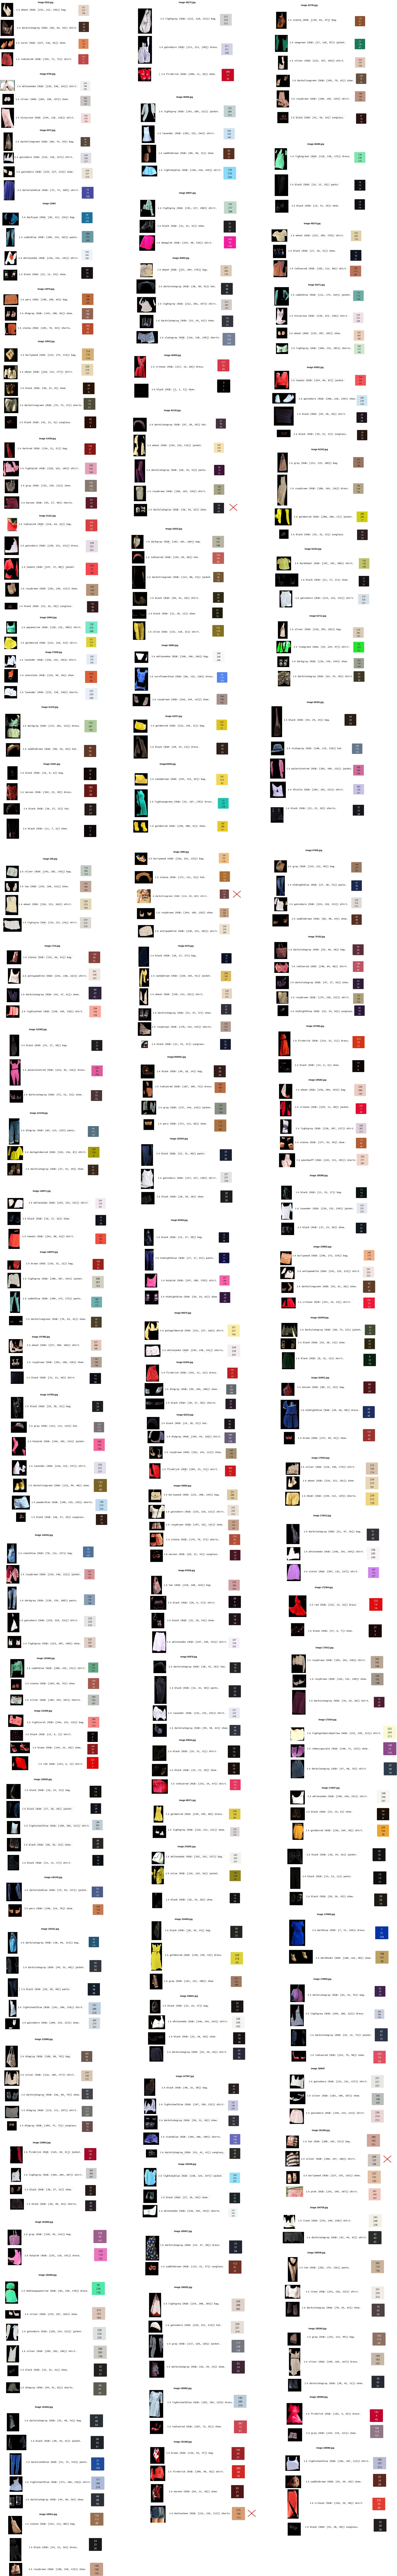

In [24]:
import os
from IPython.display import Image, display

# Path to your image
img_path = '/home/zohreh/Pictures/Screenshots/Diagram-Page-3.jpg'

# Check if the file exists
if os.path.exists(img_path):
    display(Image(filename=img_path))
else:
    print(f"File not found: {img_path}")

Manual RGB verification:

For each clothing item processed by our color extraction pipeline, we manually compared the predicted RGB values.

we used the rgb.to website to check the corresponding color for each RGB value. This website converts an RGB value to a named color (e.g., 255, 0, 0 would be "Red").

After obtaining the color name or visual representation, we compared it with the actual color of the clothing item to determine if the pipeline's prediction was accurate.

each image had a minimum of 3 and a maximum of 8 items of clothing.

Manual assessment process:

For each prediction, we evaluated whether the color extracted by the pipeline was similar to the actual color of the clothing item.
we noted down whether each prediction was correct (if the predicted color matched the actual clothing item color) or incorrect.

Final Manual Accuracy Calculation:

After comparing all items, we calculated the accuracy by dividing the number of correct predictions by the total number of predictions:
Accuracy = Number of Correct Predictions / Total Number of Predictions



In [29]:
# manual RGB verification
number_of_correctly_predicted_images = 96
total_number_of_images = 100
total_number_clothing_items = 350
total_number_correctly_predicted = 346
Accuracy_per_image = number_of_correctly_predicted_images / total_number_of_images
Accurcy_per_item = total_number_correctly_predicted / total_number_clothing_items
print(f'Accuracy per image :{Accuracy_per_image}')
print(f'Accuracy per item:{Accurcy_per_item}') 


Accuracy per image :0.96
Accuracy per item:0.9885714285714285
